## === Research Zone ===

### 1. Import Libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import networkx as nx
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from ipycytoscape import CytoscapeWidget
from cdlib import algorithms, viz, readwrite
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

Note: to be able to use all crisp methods, you need to install some additional packages:  {'karateclub', 'wurlitzer', 'infomap', 'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


### 2. Load Adjacency Matrix from Wang, Jiang, and Lin Method

In [2]:
df_wang = pd.read_excel('./../data/adjmatrix-Wang.xlsx')
df_jiang = pd.read_excel('./../data/adjmatrix-Jiang.xlsx')
df_lin = pd.read_excel('./../data/adjmatrix-Lin.xlsx')

### 3. Drop Row and Column with Null Values

In [3]:
df_wang = df_wang.dropna(axis=0, thresh=3)
df_wang = df_wang.dropna(axis=1, thresh=3)

df_jiang = df_jiang.dropna(axis=0, thresh=3)
df_jiang = df_jiang.dropna(axis=1, thresh=3)

df_lin = df_lin.dropna(axis=0, thresh=3)
df_lin = df_lin.dropna(axis=1, thresh=3)

### 4. Plot Wang, Jiang, and Lin Graphs' Edges Count

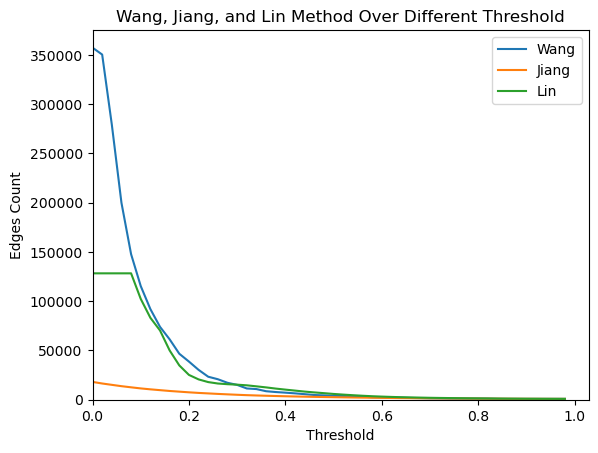

In [4]:
threshold_list = []
edges_list_wang = []
edges_list_jiang = []
edges_list_lin = []

for i in np.arange(0, 1, 0.02):
    k = copy.deepcopy(df_wang)
    k[k < i] = 0
    graph = nx.from_numpy_matrix(k.values)
    graph = nx.relabel_nodes(graph, dict(enumerate(k.columns)))
    edges = graph.number_of_edges()
    threshold_list.append(i)
    edges_list_wang.append(edges)
    
    k = copy.deepcopy(df_jiang)
    k[k < i] = 0
    graph = nx.from_numpy_matrix(k.values)
    graph = nx.relabel_nodes(graph, dict(enumerate(k.columns)))
    edges = graph.number_of_edges()
    edges_list_jiang.append(edges)
    
    k = copy.deepcopy(df_lin)
    k[k < i] = 0
    graph = nx.from_numpy_matrix(k.values)
    graph = nx.relabel_nodes(graph, dict(enumerate(k.columns)))
    edges = graph.number_of_edges()
    edges_list_lin.append(edges)

plt.title("Wang, Jiang, and Lin Method Over Different Threshold")
plt.plot(threshold_list, edges_list_wang)
plt.plot(threshold_list, edges_list_jiang)
plt.plot(threshold_list, edges_list_lin)
plt.xlim(0)
plt.ylim(0)
plt.xlabel("Threshold")
plt.ylabel("Edges Count")
plt.legend(['Wang', 'Jiang', 'Lin'])
plt.show()

### 5. Choose 0.5 as Threshold and Wang Method, Make The Graph and See The Nodes Degree Distribution

Nodes that will be used as giant component: 323


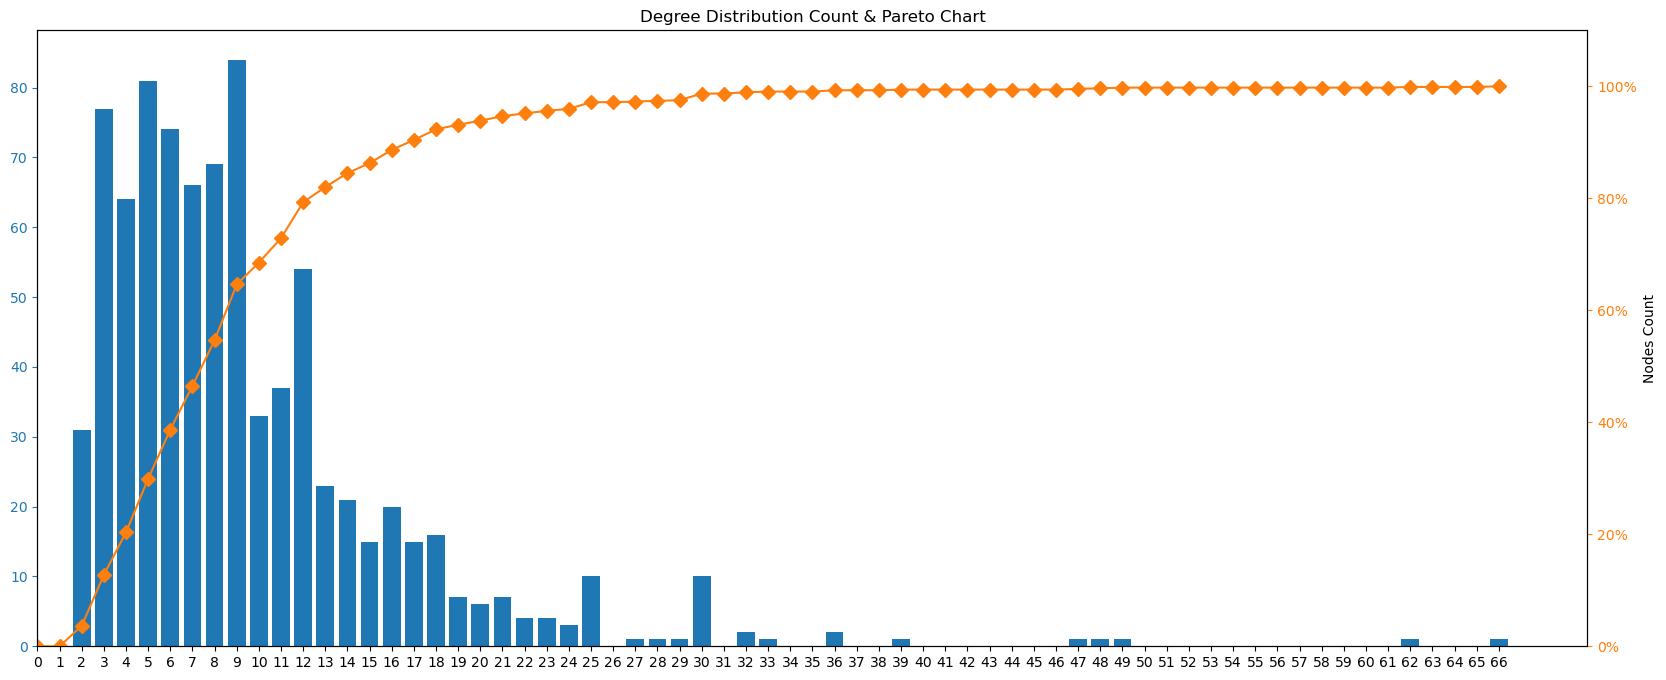

In [5]:
df_wang[df_wang < 0.5] = 0

graph = nx.from_numpy_matrix(df_wang.values)
graph = nx.relabel_nodes(graph, dict(enumerate(df_wang.columns)))
nodes_of_largest_component  = max(nx.connected_components(graph), key = len)
print("Nodes that will be used as giant component: " + str(len(nodes_of_largest_component)))
g = graph.subgraph(nodes_of_largest_component)
degree = graph.degree()

degree_dic = {}
for nodes, deg in degree:
    if deg not in degree_dic:
        degree_dic[deg] = 1
    else:
        degree_dic[deg] += 1

for i in range(0, 67):
    if i not in degree_dic:
        degree_dic[i] = 0
k = sorted(degree_dic.items())
    
data = pd.DataFrame(k, columns =['Degree', 'Count'])
data["cumpercentage"] = data["Count"].cumsum()/data["Count"].sum()*100

fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(data["Degree"], data["Count"], color="C0")
ax2 = ax.twinx()
ax2.plot(data["Degree"], data["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.xlim(0, 70)
plt.ylim(0, 110)
plt.xlabel("Degree")
plt.ylabel("Nodes Count")
plt.title("Degree Distribution Count & Pareto Chart")
plt.xticks(range(0, 67))
plt.show()

### 6. Plot The Largest Component Beside The Rest of The Graph

In [6]:
cyto = CytoscapeWidget()

for node in g.nodes(data=True):
    node[1]["classes"] = 'classRey'
    
for s, t, data in g.edges(data=True):
    g[s][t]['classes'] = 'classRey'
    
cyto.graph.add_graph_from_networkx(graph)
cyto.set_style(
    [
        {
             'selector': 'node.classRey',
             'style': {
                 'background-color': 'green'
             }
        },
        {
             'selector': 'edge.classRey',
             'style': {
                 'line-color': '#A0FFA0'
             }
        }
    ]
)
display(cyto)

### 7. Plot The Larget Component On Its Own

In [7]:
cyto_largest = CytoscapeWidget()
cyto_largest.graph.add_graph_from_networkx(g)
cyto_largest.set_style(
    [
        {
             'selector': 'node',
             'style': {
                 'background-color': 'green'
             }
        },
        {
             'selector': 'edge',
             'style': {
                 'line-color': '#A0FFA0'
             }
        }
    ]
)
display(cyto_largest)

### 8. Initialize The Position of Graph and Get The Communities with All Algorithms

In [8]:
random_pos = nx.random_layout(g, seed=42)

coms_af = algorithms.async_fluid(g, k=7)
coms_bel = algorithms.belief(g)
coms_cpm = algorithms.cpm(g)
coms_cw = algorithms.chinesewhispers(nx.Graph(g))
coms_der = algorithms.der(g)
coms_ev = algorithms.eigenvector(g)
coms_em = algorithms.em(nx.Graph(g), k=10)
coms_ga = algorithms.ga(g)
coms_gn = algorithms.girvan_newman(g, level=5)
coms_gm = algorithms.greedy_modularity(g)
coms_kc = algorithms.kcut(nx.Graph(g), kmax=4)
coms_lp = algorithms.label_propagation(g)
coms_lei = algorithms.leiden(g)
coms_lou = algorithms.louvain(g)
coms_mc = algorithms.markov_clustering(nx.Graph(g))
coms_rber = algorithms.rber_pots(g)
coms_rbp = algorithms.rb_pots(g)
coms_sic = algorithms.significance_communities(g)
coms_sg = algorithms.spinglass(g)
coms_sc = algorithms.surprise_communities(g)
coms_wt = algorithms.walktrap(g)

readwrite.write_community_csv(coms_lei, "leiden-communities.csv", ",")
readwrite.write_community_csv(coms_sg, "spinglass-communities.csv", ",")
readwrite.write_community_csv(coms_rber, "rberpots-communities.csv", ",")
readwrite.write_community_csv(coms_rbp, "rbpots-communities.csv", ",")
readwrite.write_community_csv(coms_lou, "louvain-communities.csv", ",")
readwrite.write_community_csv(coms_wt, "walktrap-communities.csv", ",")

### 9.a.1. Using Async Fluid as Community Algorithm - Network Cluster

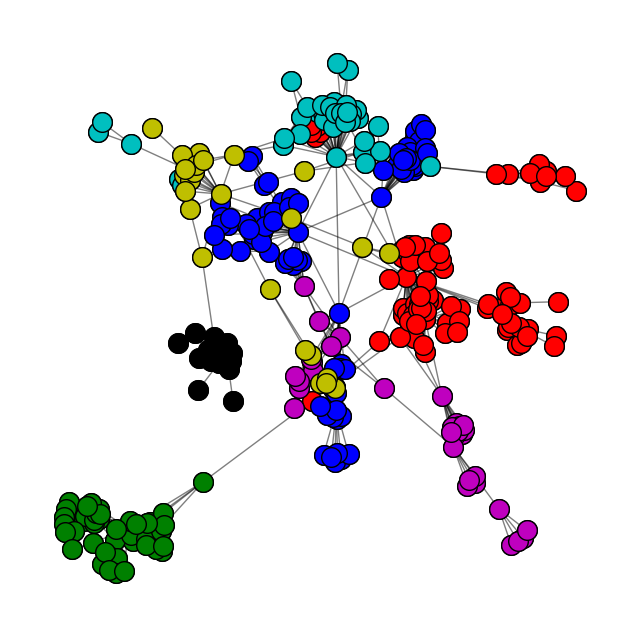

In [9]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_af, pos)

### 9.a.2. Plot the Community Graph

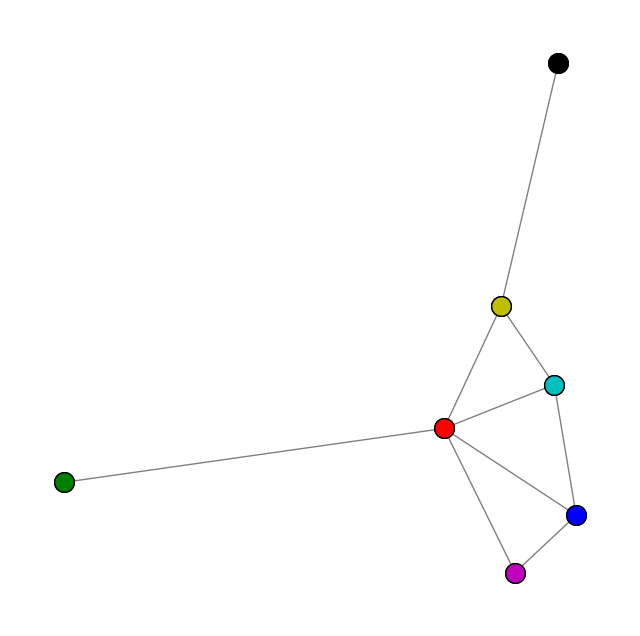

In [10]:
viz.plot_community_graph(g, coms_af)

### 9.a.3. Evaluate the Modularity

In [11]:
from cdlib import evaluation

algorithm = "async fluid"
m1 = evaluation.erdos_renyi_modularity(g, coms_af)
m2 = evaluation.link_modularity(g, coms_af)
m3 = evaluation.modularity_density(g, coms_af)
m4 = evaluation.newman_girvan_modularity(g, coms_af)
m5 = evaluation.z_modularity(g, coms_af)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

eval_table = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

0.7912533816784275
0.1065566640074442
55.83290019050561
0.7817761454166775
2.011704767087462


### 9.b.1. Using Belief as Community Algorithm - Network Cluster

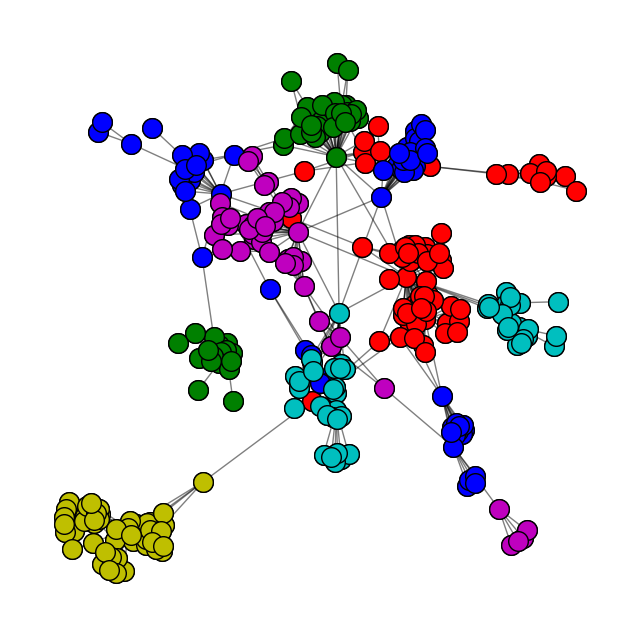

In [12]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_bel, pos)

### 9.b.2. Plot the Community Graph

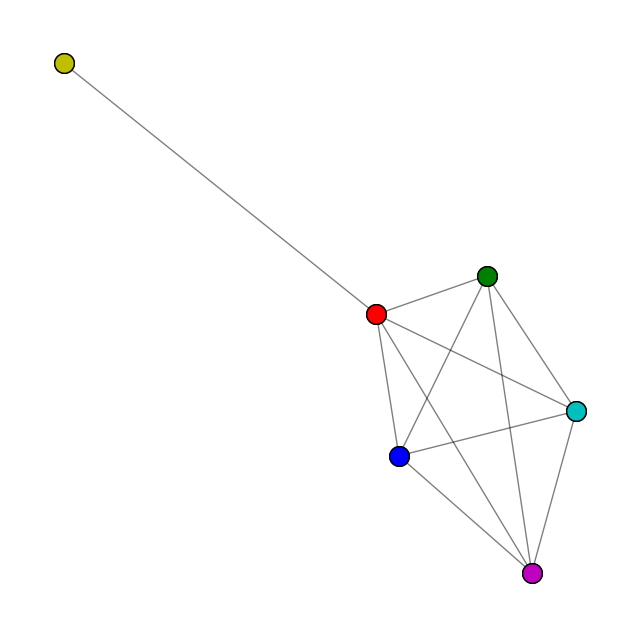

In [13]:
viz.plot_community_graph(g, coms_bel)

### 9.b.3. Evaluate the Modularity

In [14]:
algorithm = "belief"
m1 = evaluation.erdos_renyi_modularity(g, coms_bel)
m2 = evaluation.link_modularity(g, coms_bel)
m3 = evaluation.modularity_density(g, coms_bel)
m4 = evaluation.newman_girvan_modularity(g, coms_bel)
m5 = evaluation.z_modularity(g, coms_bel)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8090919451292294
0.10800229796502611
49.49999822013475
0.8043380352873266
2.127357423212041


### 9.c.1. Using CPM as Community Algorithm - Network Cluster

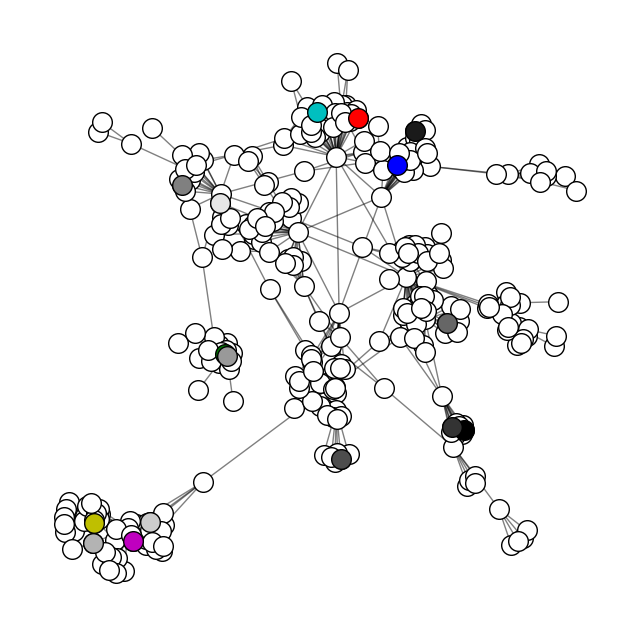

In [15]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_cpm, pos)

### 9.c.2. Plot the Community Graph

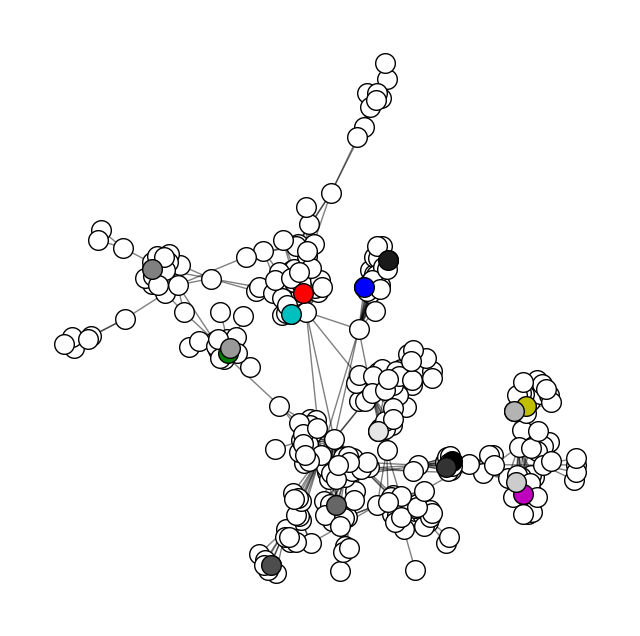

In [16]:
viz.plot_community_graph(g, coms_cpm)

### 9.c.3. Evaluate the Modularity

In [17]:
algorithm = "cpm"
m1 = evaluation.erdos_renyi_modularity(g, coms_cpm)
m2 = evaluation.link_modularity(g, coms_cpm)
m3 = evaluation.modularity_density(g, coms_cpm)
m4 = evaluation.newman_girvan_modularity(g, coms_cpm)
m5 = evaluation.z_modularity(g, coms_cpm)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.2305496074232691
0.0
-1510.0
0.2261862002311999
3.4316485879321283


### 9.d.1. Using Chinese Whispers as Community Algorithm - Network Cluster

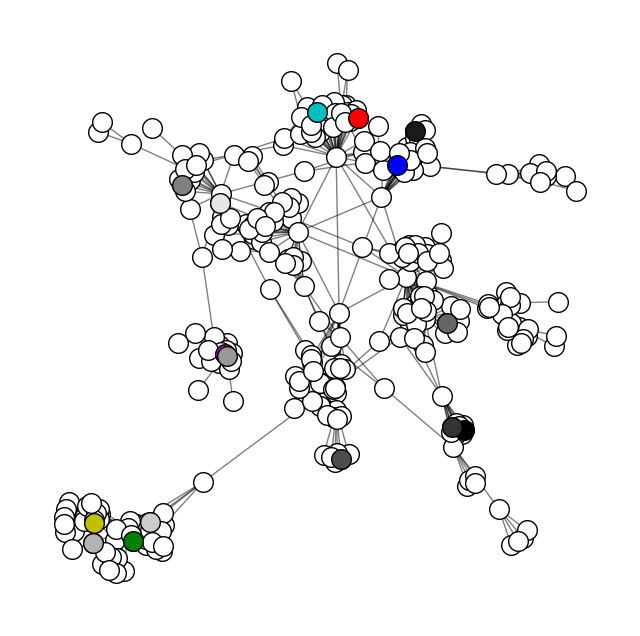

In [18]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_cw, pos)

### 9.d.2. Plot the Community Graph

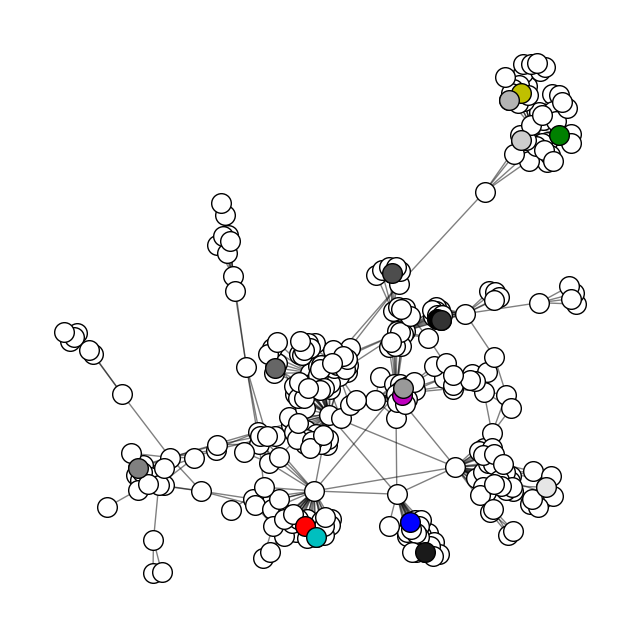

In [19]:
viz.plot_community_graph(g, coms_cw)

### 9.d.3. Evaluate the Modularity

In [20]:
algorithm = "chinese whispers"
m1 = evaluation.erdos_renyi_modularity(g, coms_cw)
m2 = evaluation.link_modularity(g, coms_cw)
m3 = evaluation.modularity_density(g, coms_cw)
m4 = evaluation.newman_girvan_modularity(g, coms_cw)
m5 = evaluation.z_modularity(g, coms_cw)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.2305496074232691
0.0
-1510.0
0.2261862002311999
3.4316485879321283


### 9.e.1. Using DER as Community Algorithm - Network Cluster

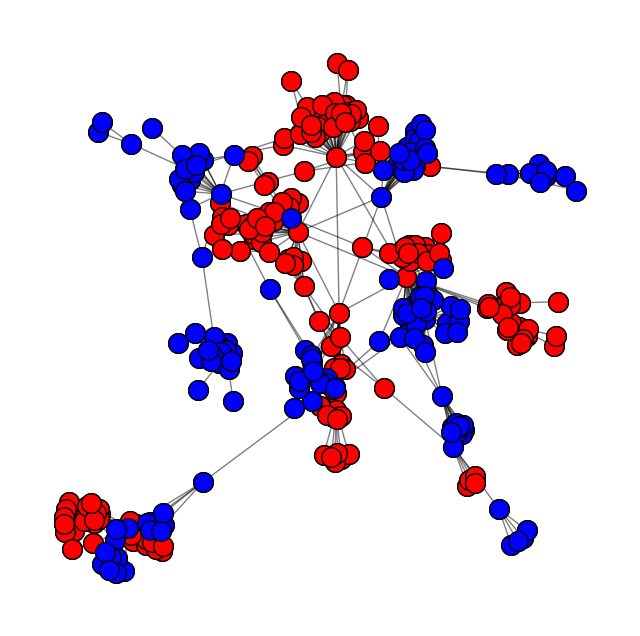

In [21]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_der, pos)

### 9.e.2. Plot the Community Graph

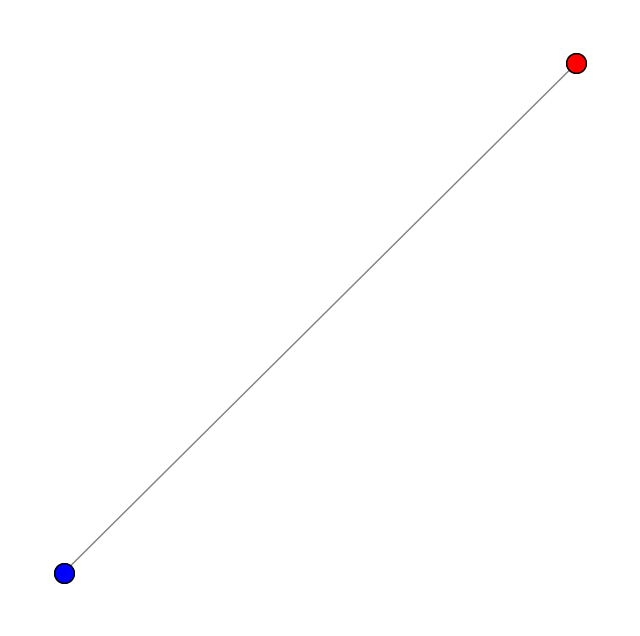

In [22]:
viz.plot_community_graph(g, coms_der)

### 9.e.3. Evaluate the Modularity

In [23]:
algorithm = "der"
m1 = evaluation.erdos_renyi_modularity(g, coms_der)
m2 = evaluation.link_modularity(g, coms_der)
m3 = evaluation.modularity_density(g, coms_der)
m4 = evaluation.newman_girvan_modularity(g, coms_der)
m5 = evaluation.z_modularity(g, coms_der)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.44375820683380934
0.10325280093183303
15.44540274141383
0.44376276555799593
0.8875260931856769


### 9.f.1. Using Eigenvector as Community Algorithm - Network Cluster

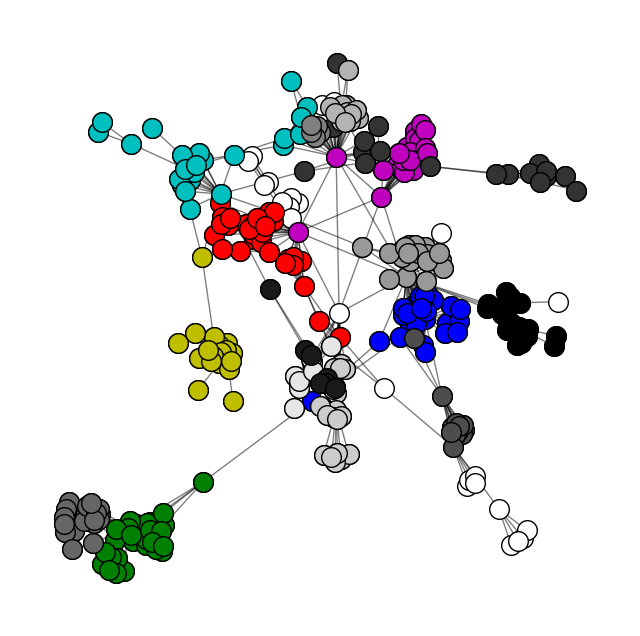

In [24]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_ev, pos)

### 9.f.2. Plot the Community Graph

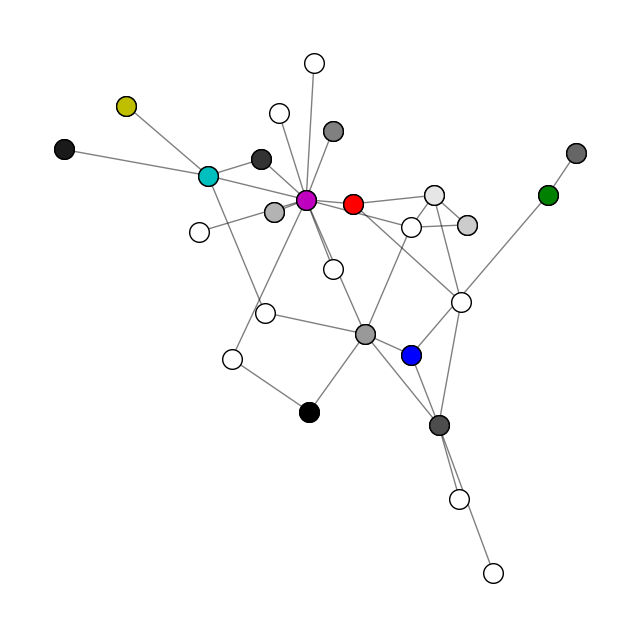

In [25]:
viz.plot_community_graph(g, coms_ev)

### 9.f.3. Evaluate the Modularity

In [26]:
### 9.a.3. Evaluate the Modularityalgorithm = "eigenvector"
m1 = evaluation.erdos_renyi_modularity(g, coms_ev)
m2 = evaluation.link_modularity(g, coms_ev)
m3 = evaluation.modularity_density(g, coms_ev)
m4 = evaluation.newman_girvan_modularity(g, coms_ev)
m5 = evaluation.z_modularity(g, coms_ev)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8397818371072672
0.09664501646886146
122.02863472784526
0.8291650554488206
3.2610074118889814


### 9.g.1. Using EM as Community Algorithm - Network Cluster

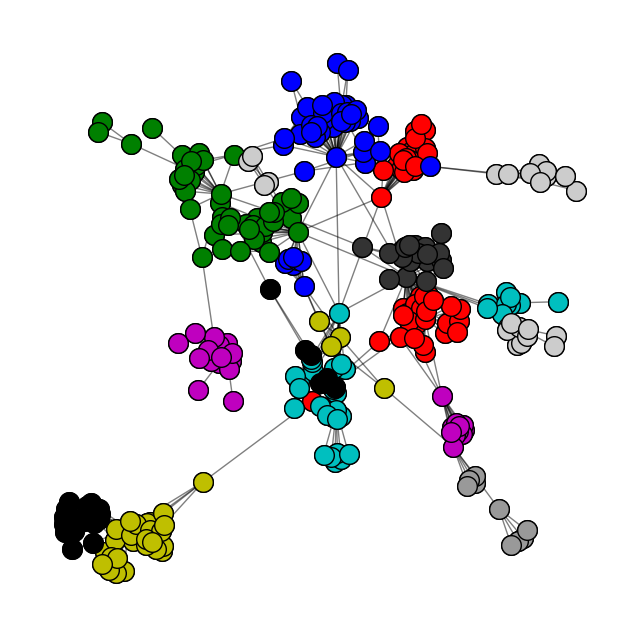

In [27]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_em, pos)

### 9.g.2. Plot the Community Graph

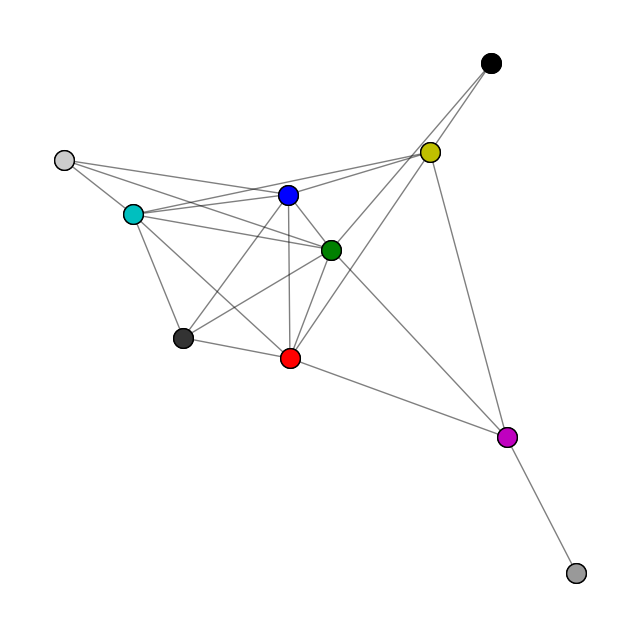

In [28]:
viz.plot_community_graph(g, coms_em)

### 9.g.3. Evaluate the Modularity

In [29]:
algorithm = "em"
m1 = evaluation.erdos_renyi_modularity(g, coms_em)
m2 = evaluation.link_modularity(g, coms_em)
m3 = evaluation.modularity_density(g, coms_em)
m4 = evaluation.newman_girvan_modularity(g, coms_em)
m5 = evaluation.z_modularity(g, coms_em)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8180971632573278
0.10129133416838867
71.00103757518268
0.809597101285357
2.4809850467286965


### 9.h.1. Using GA as Community Algorithm - Network Cluster

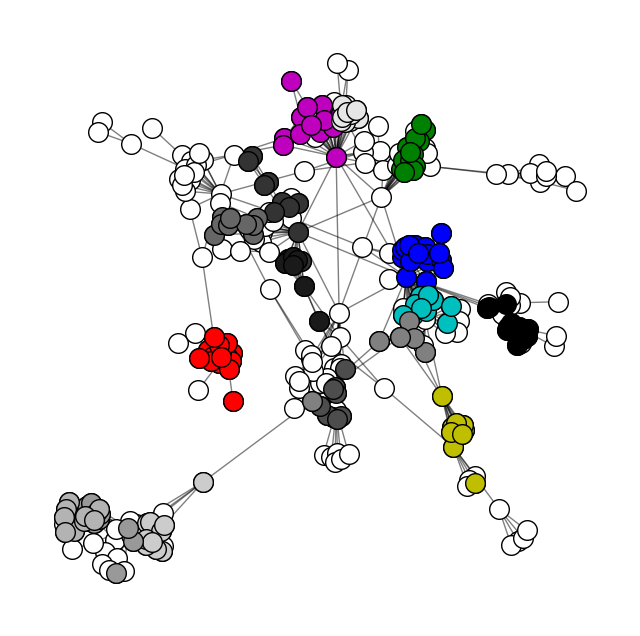

In [30]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_ga, pos)

### 9.h.2. Plot the Community Graph

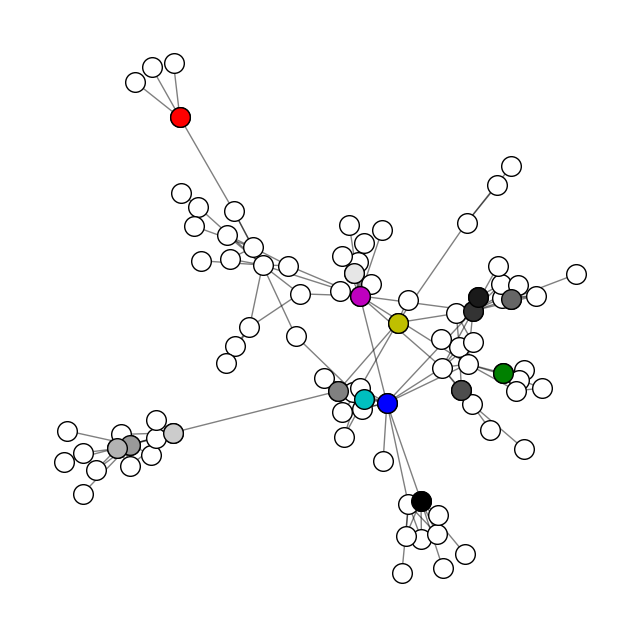

In [31]:
viz.plot_community_graph(g, coms_ga)

### 9.h.3. Evaluate the Modularity

In [32]:
algorithm = "ga"
m1 = evaluation.erdos_renyi_modularity(g, coms_ga)
m2 = evaluation.link_modularity(g, coms_ga)
m3 = evaluation.modularity_density(g, coms_ga)
m4 = evaluation.newman_girvan_modularity(g, coms_ga)
m5 = evaluation.z_modularity(g, coms_ga)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.6486598677122938
0.06360415813755044
38.95667600373481
0.6363067371577656
3.5146141173965124


### 9.i.1. Using Girvan Newman as Community Algorithm - Network Cluster

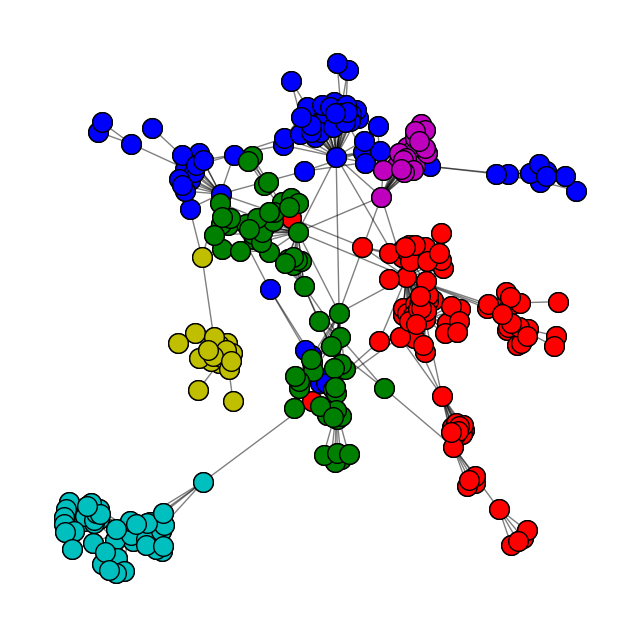

In [33]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_gn, pos)

### 9.i.2. Plot the Community Graph

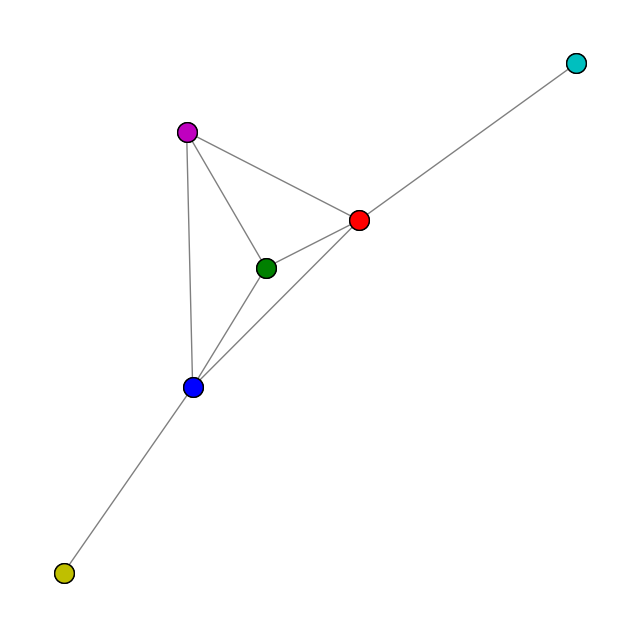

In [34]:
viz.plot_community_graph(g, coms_gn)

### 9.i.3. Evaluate the Modularity

In [35]:
algorithm = "girvan newman"
m1 = evaluation.erdos_renyi_modularity(g, coms_gn)
m2 = evaluation.link_modularity(g, coms_gn)
m3 = evaluation.modularity_density(g, coms_gn)
m4 = evaluation.newman_girvan_modularity(g, coms_gn)
m5 = evaluation.z_modularity(g, coms_gn)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.7848266674012643
0.1098606955177257
54.136951170455006
0.7891350167439287
1.9696240625506558


### 9.j.1. Using Greedy Modularity as Community Algorithm - Network Cluster

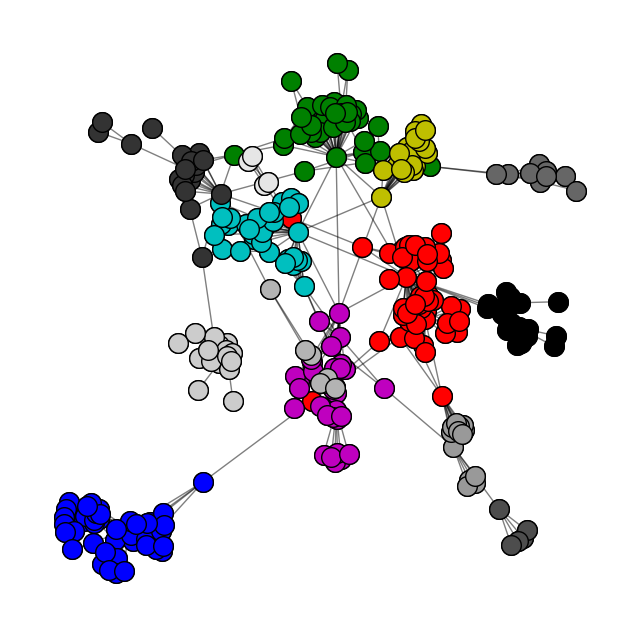

In [36]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_gm, pos)

### 9.j.2. Plot the Community Graph

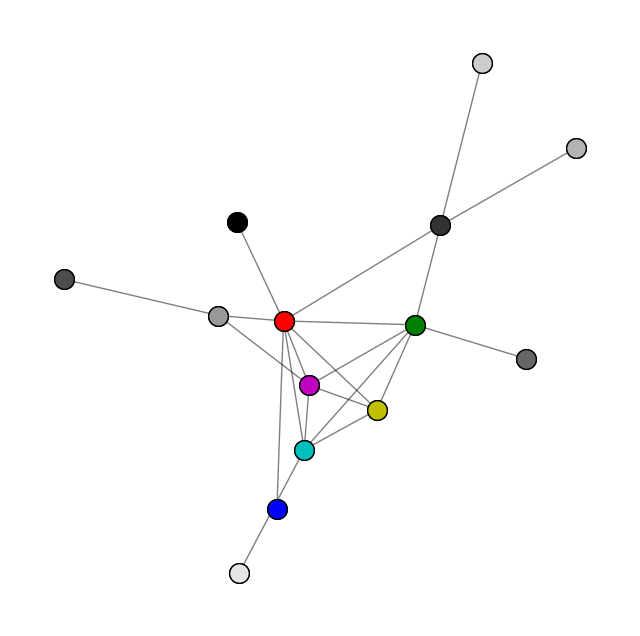

In [37]:
viz.plot_community_graph(g, coms_gm)

### 9.j.3. Evaluate the Modularity

In [38]:
algorithm = "greedy modularity"
m1 = evaluation.erdos_renyi_modularity(g, coms_gm)
m2 = evaluation.link_modularity(g, coms_gm)
m3 = evaluation.modularity_density(g, coms_gm)
m4 = evaluation.newman_girvan_modularity(g, coms_gm)
m5 = evaluation.z_modularity(g, coms_gm)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8740507379996182
0.10717625189015946
106.1353735577178
0.867665647205193
2.844998987043929


### 9.k.1. Using KCut as Community Algorithm - Network Cluster

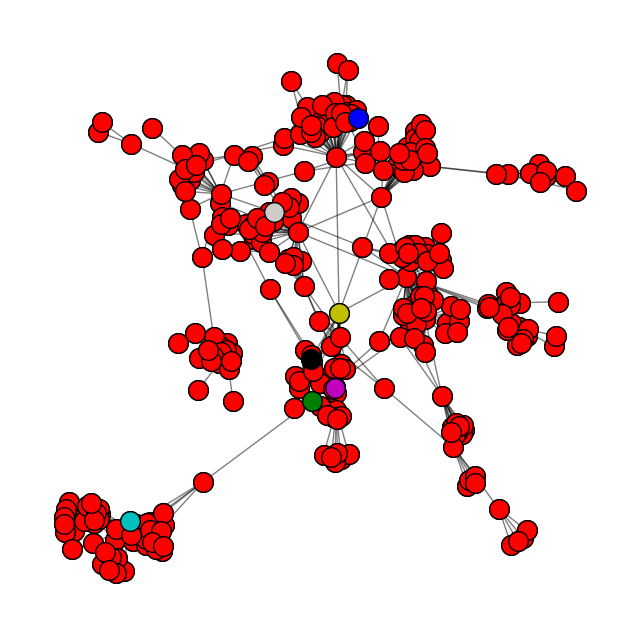

In [39]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_kc, pos)

### 9.k.2. Plot the Community Graph

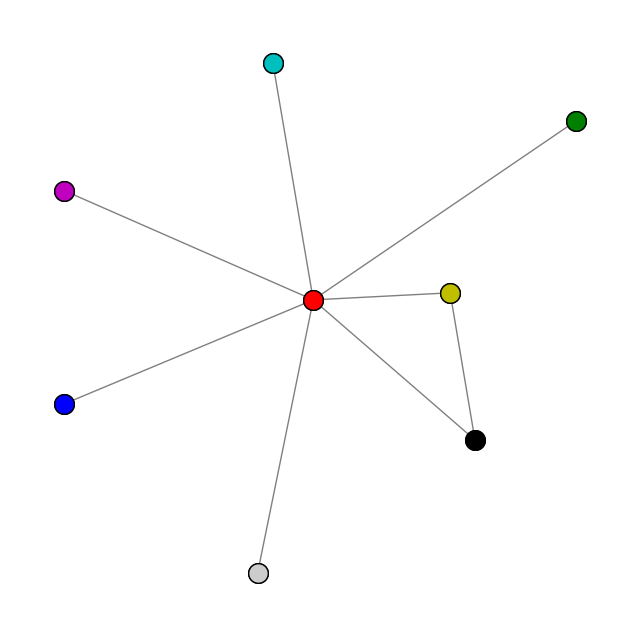

In [40]:
viz.plot_community_graph(g, coms_kc)

### 9.k.3. Evaluate the Modularity

In [41]:
algorithm = "kcut"
m1 = evaluation.erdos_renyi_modularity(g, coms_kc)
m2 = evaluation.link_modularity(g, coms_kc)
m3 = evaluation.modularity_density(g, coms_kc)
m4 = evaluation.newman_girvan_modularity(g, coms_kc)
m5 = evaluation.z_modularity(g, coms_kc)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.015102571293757883
0.10727895409392205
-17.544303797468352
0.010267979280630156
0.05363260138604836


### 9.l.1. Using Label Propagation as Community Algorithm - Network Cluster

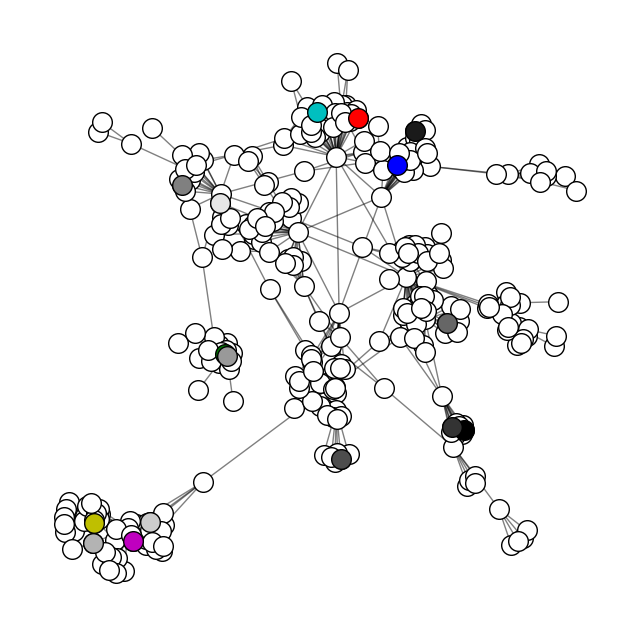

In [42]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_lp, pos)

### 9.l.2. Plot the Community Graph

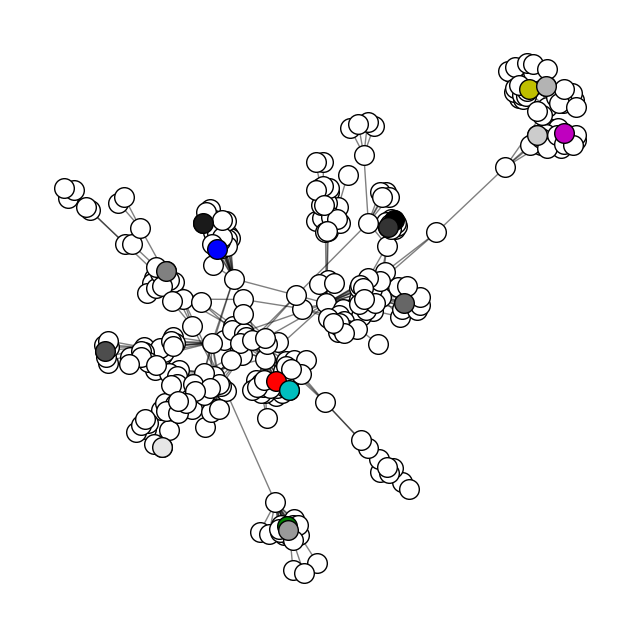

In [43]:
viz.plot_community_graph(g, coms_lp)

### 9.l.3. Evaluate the Modularity

In [44]:
algorithm = "label propagation"
m1 = evaluation.erdos_renyi_modularity(g, coms_lp)
m2 = evaluation.link_modularity(g, coms_lp)
m3 = evaluation.modularity_density(g, coms_lp)
m4 = evaluation.newman_girvan_modularity(g, coms_lp)
m5 = evaluation.z_modularity(g, coms_lp)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.2305496074232691
0.0
-1510.0
0.2261862002311999
3.4316485879321283


### 9.m.1. Using Leiden as Community Algorithm - Network Cluster

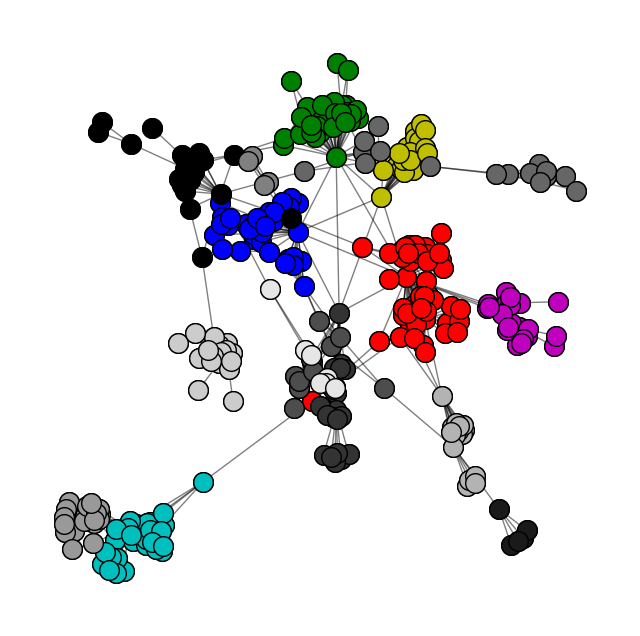

In [45]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_lei, pos)

### 9.m.2. Plot the Community Graph

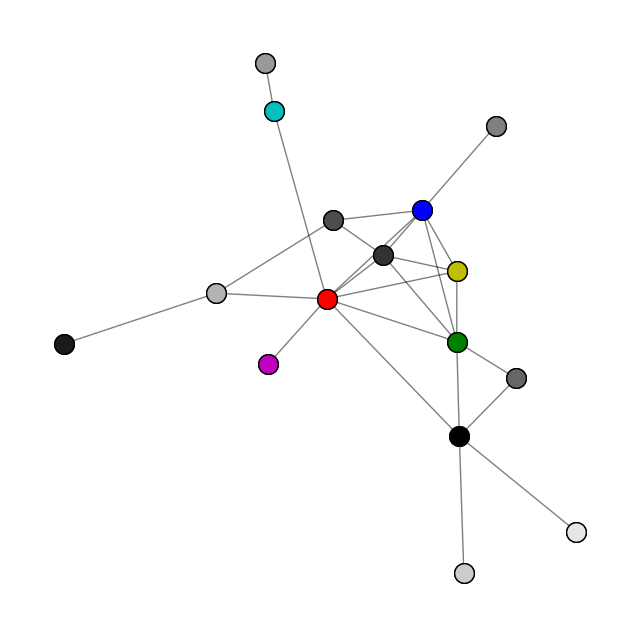

In [46]:
viz.plot_community_graph(g, coms_lei)

### 9.m.3. Evaluate the Modularity

In [47]:
algorithm = "leiden"
m1 = evaluation.erdos_renyi_modularity(g, coms_lei)
m2 = evaluation.link_modularity(g, coms_lei)
m3 = evaluation.modularity_density(g, coms_lei)
m4 = evaluation.newman_girvan_modularity(g, coms_lei)
m5 = evaluation.z_modularity(g, coms_lei)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8853734526900885
0.1061438357413306
120.10330344258917
0.8774598138069016
3.1157895193227323


### 9.n.1. Using Louvain as Community Algorithm - Network Cluster

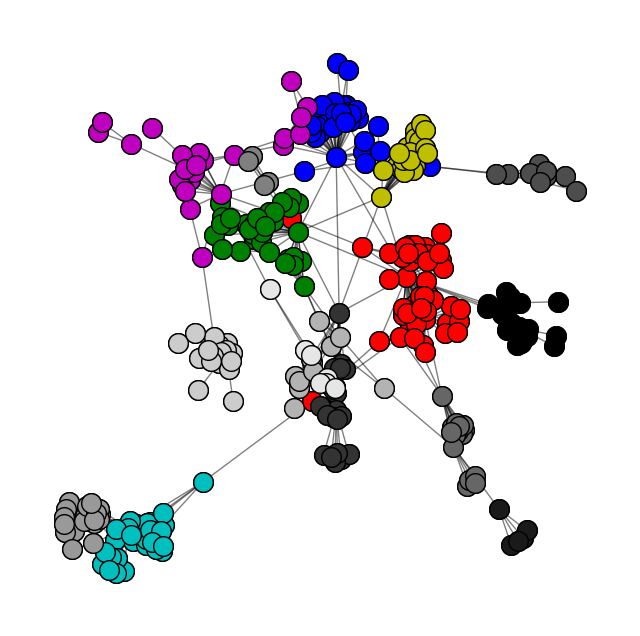

In [48]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_lou, pos)

### 9.n.2. Plot the Community Graph

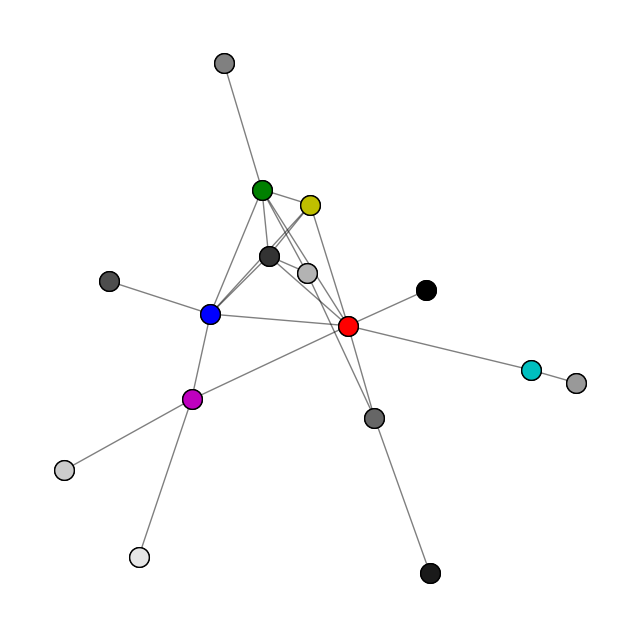

In [49]:
viz.plot_community_graph(g, coms_lou)

### 9.n.3. Evaluate the Modularity

In [50]:
algorithm = "louvain"
m1 = evaluation.erdos_renyi_modularity(g, coms_lou)
m2 = evaluation.link_modularity(g, coms_lou)
m3 = evaluation.modularity_density(g, coms_lou)
m4 = evaluation.newman_girvan_modularity(g, coms_lou)
m5 = evaluation.z_modularity(g, coms_lou)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8832005011296017
0.10614383235770937
120.17102446573034
0.8759089688664313
3.085501199403977


### 9.o.1. Using Markov Clustering as Community Algorithm - Network Cluster

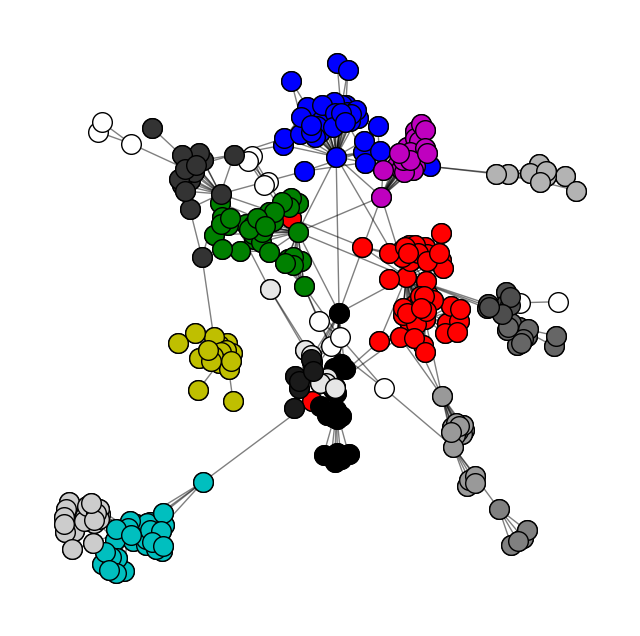

In [51]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_mc, pos)

### 9.o.2. Plot the Community Graph

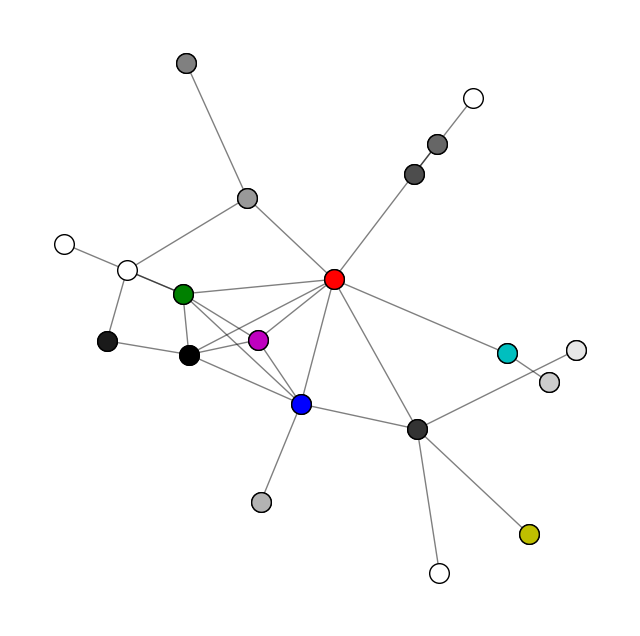

In [52]:
viz.plot_community_graph(g, coms_mc)

### 9.o.3. Evaluate the Modularity

In [53]:
algorithm = "markov clustering"
m1 = evaluation.erdos_renyi_modularity(g, coms_mc)
m2 = evaluation.link_modularity(g, coms_mc)
m3 = evaluation.modularity_density(g, coms_mc)
m4 = evaluation.newman_girvan_modularity(g, coms_mc)
m5 = evaluation.z_modularity(g, coms_mc)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.872157844953847
0.10418202955762215
129.98508785332314
0.8642687159829243
3.0748945072810585


### 9.p.1. Using RBer Pots as Community Algorithm - Network Cluster

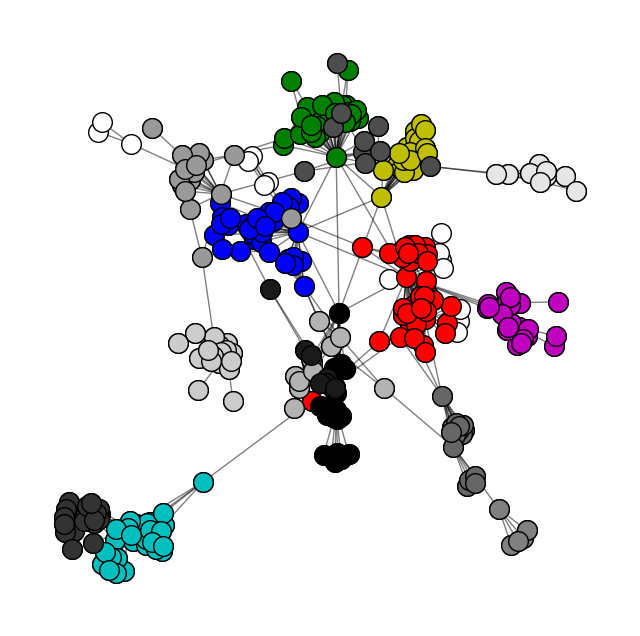

In [54]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_rber, pos)

### 9.p.2. Plot the Community Graph

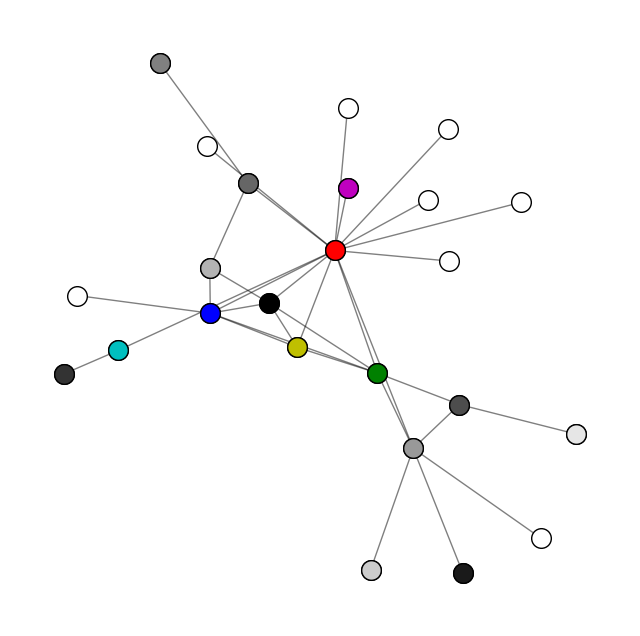

In [55]:
viz.plot_community_graph(g, coms_rber)

### 9.p.3. Evaluate the Modularity

In [56]:
algorithm = "rber pots"
m1 = evaluation.erdos_renyi_modularity(g, coms_rber)
m2 = evaluation.link_modularity(g, coms_rber)
m3 = evaluation.modularity_density(g, coms_rber)
m4 = evaluation.newman_girvan_modularity(g, coms_rber)
m5 = evaluation.z_modularity(g, coms_rber)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8871921585043346
0.10490485972815289
136.7763294970612
0.8737806328812753
3.1853557233649563


### 9.q.1. Using RB Pots as Community Algorithm - Network Cluster

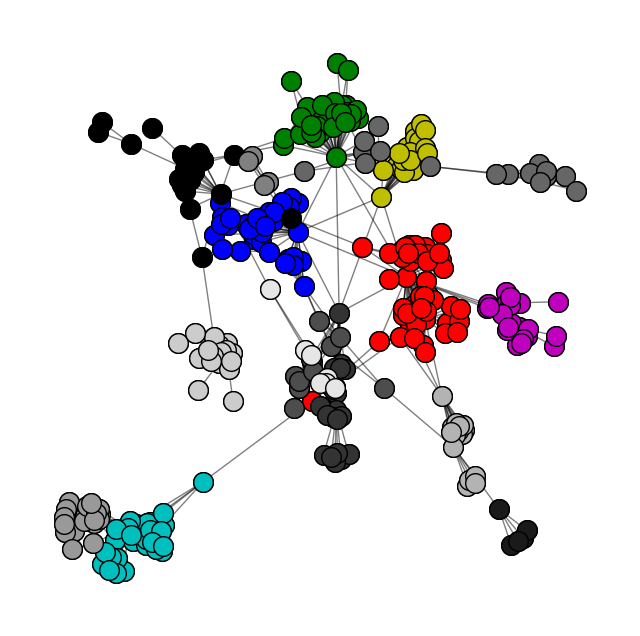

In [57]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_rbp, pos)

### 9.q.2. Plot the Community Graph

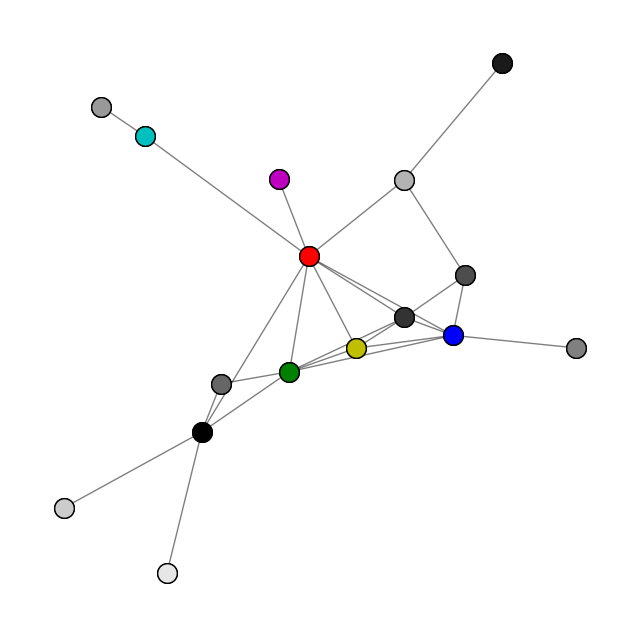

In [58]:
viz.plot_community_graph(g, coms_rbp)

### 9.q.3. Evaluate the Modularity

In [59]:
algorithm = "rb pots"
m1 = evaluation.erdos_renyi_modularity(g, coms_rbp)
m2 = evaluation.link_modularity(g, coms_rbp)
m3 = evaluation.modularity_density(g, coms_rbp)
m4 = evaluation.newman_girvan_modularity(g, coms_rbp)
m5 = evaluation.z_modularity(g, coms_rbp)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8853734526900885
0.1061438357413306
120.10330344258917
0.8774598138069016
3.1157895193227323


### 9.r.1. Using Significance Communities as Community Algorithm - Network Cluster

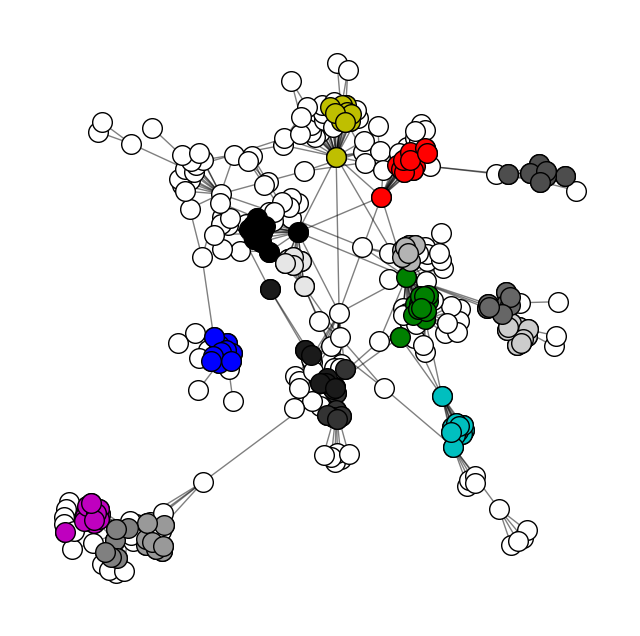

In [60]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_sic, pos)

### 9.r.2. Plot the Community Graph

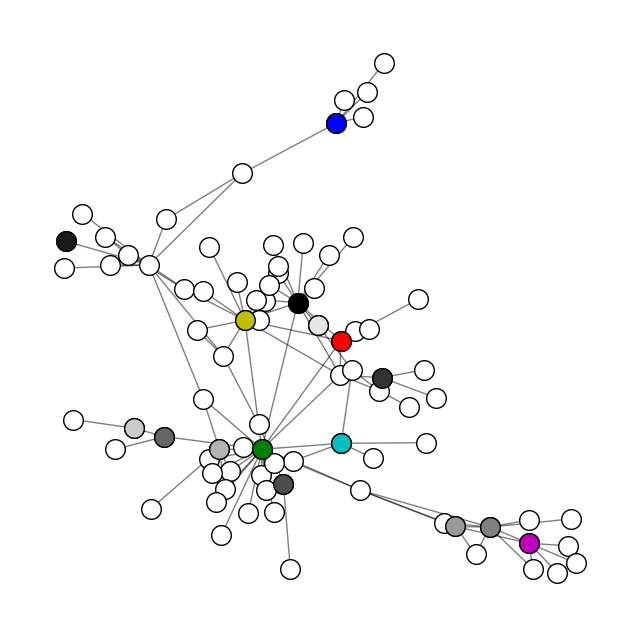

In [61]:
viz.plot_community_graph(g, coms_sic)

### 9.r.3. Evaluate the Modularity

In [62]:
algorithm = "significance communities"
m1 = evaluation.erdos_renyi_modularity(g, coms_sic)
m2 = evaluation.link_modularity(g, coms_sic)
m3 = evaluation.modularity_density(g, coms_sic)
m4 = evaluation.newman_girvan_modularity(g, coms_sic)
m5 = evaluation.z_modularity(g, coms_sic)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.7224727865656134
0.07361968852523644
180.67283827283828
0.7044700405186259
3.8331365837196945


### 9.s.1. Using Spinglass as Community Algorithm - Network Cluster

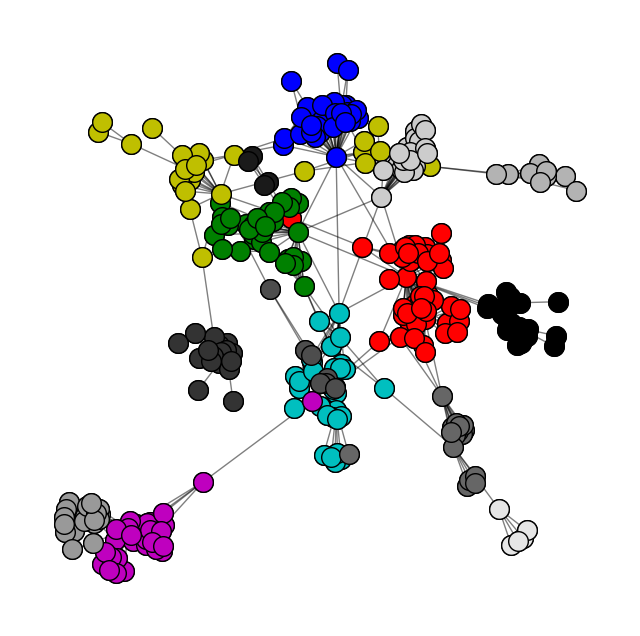

In [63]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_sg, pos)

### 9.s.2. Plot the Community Graph

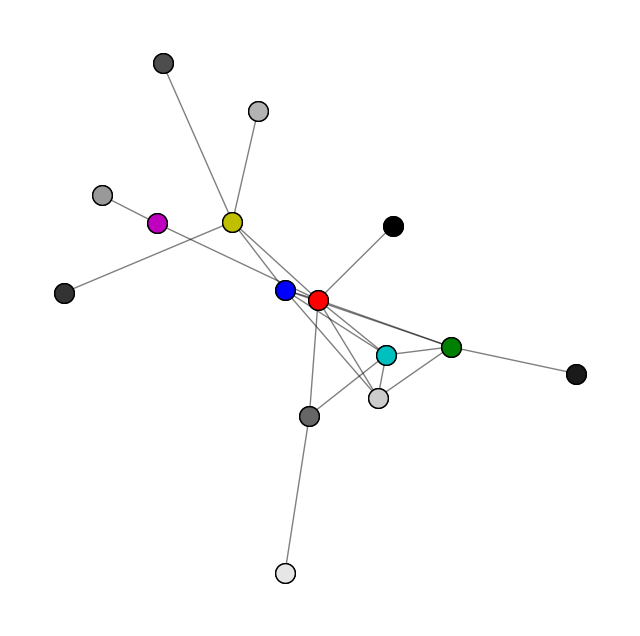

In [64]:
viz.plot_community_graph(g, coms_sg)

### 9.s.3. Evaluate the Modularity

In [65]:
algorithm = "spinglass"
m1 = evaluation.erdos_renyi_modularity(g, coms_sg)
m2 = evaluation.link_modularity(g, coms_sg)
m3 = evaluation.modularity_density(g, coms_sg)
m4 = evaluation.newman_girvan_modularity(g, coms_sg)
m5 = evaluation.z_modularity(g, coms_sg)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8805298568743692
0.10624709087226354
113.8863430220573
0.8742045169123105
3.0422602237562537


### 9.t.1. Using Surprise Communities as Community Algorithm - Network Cluster

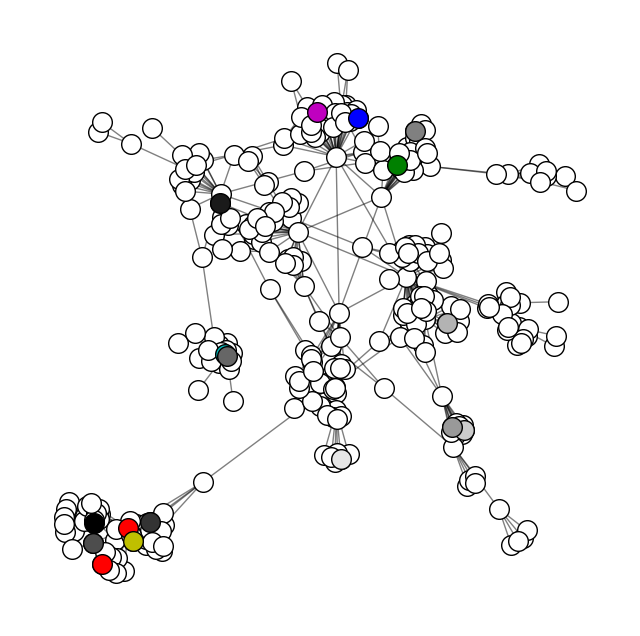

In [66]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_sc, pos)

### 9.t.2. Plot the Community Graph

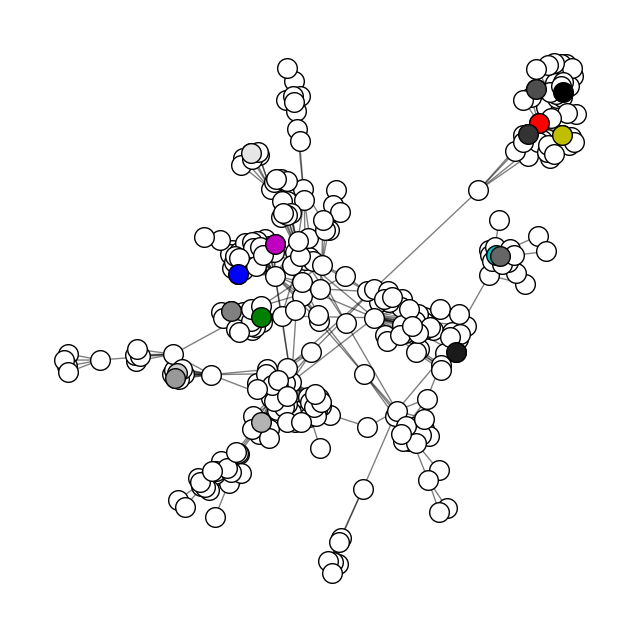

In [67]:
viz.plot_community_graph(g, coms_sc)

### 9.t.3. Evaluate the Modularity

In [68]:
algorithm = "surprise communities"
m1 = evaluation.erdos_renyi_modularity(g, coms_sc)
m2 = evaluation.link_modularity(g, coms_sc)
m3 = evaluation.modularity_density(g, coms_sc)
m4 = evaluation.newman_girvan_modularity(g, coms_sc)
m5 = evaluation.z_modularity(g, coms_sc)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.2312441536378172
0.00010325408281884016
-1496.0
0.22687781389962577
3.4334714745637602


### 9.u.1. Using Walktrap as Community Algorithm - Network Cluster

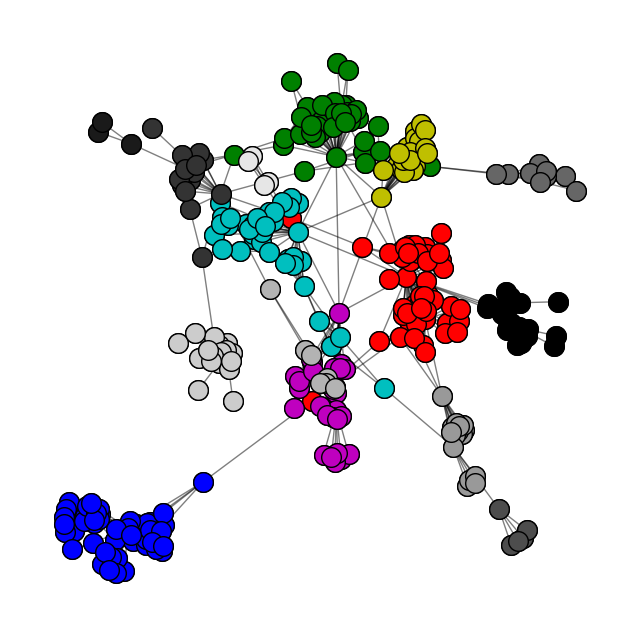

In [69]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_wt, pos)

### 9.u.2. Plot the Community Graph

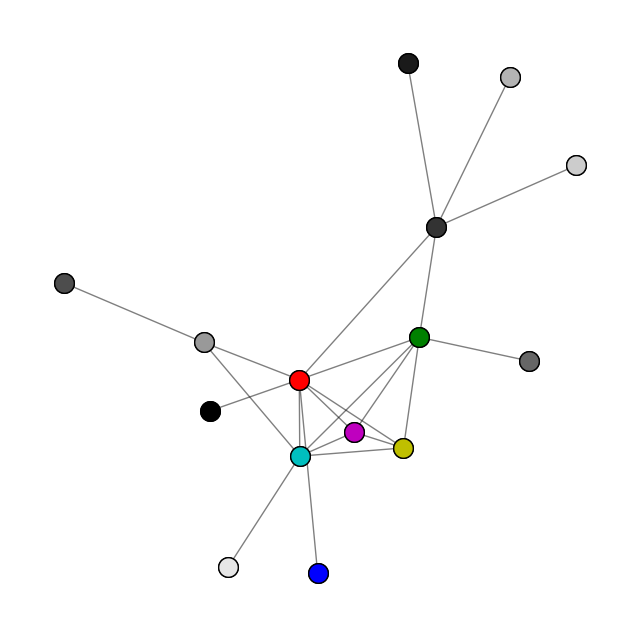

In [70]:
viz.plot_community_graph(g, coms_wt)

### 9.u.3. Evaluate the Modularity

In [71]:
algorithm = "walktrap"
m1 = evaluation.erdos_renyi_modularity(g, coms_wt)
m2 = evaluation.link_modularity(g, coms_wt)
m3 = evaluation.modularity_density(g, coms_wt)
m4 = evaluation.newman_girvan_modularity(g, coms_wt)
m5 = evaluation.z_modularity(g, coms_wt)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8794871728355098
0.10779577486964903
110.76993752859605
0.8729458564571754
2.874569055630773


### 10. Get the Result of Each Algorithm Modularity Score

In [72]:
eval_table.sort_values(by='Erdos Renyi Mod.', ascending=False)

Algorithm  Erdos Renyi Mod.  Link Mod.  Mod. Density  \
0                 rber pots          0.887192   0.104905    136.776329   
0                    leiden          0.885373   0.106144    120.103303   
0                   rb pots          0.885373   0.106144    120.103303   
0                   louvain          0.883201   0.106144    120.171024   
0                 spinglass          0.880530   0.106247    113.886343   
0                  walktrap          0.879487   0.107796    110.769938   
0         greedy modularity          0.874051   0.107176    106.135374   
0         markov clustering          0.872158   0.104182    129.985088   
0                       der          0.839782   0.096645    122.028635   
0                        em          0.818097   0.101291     71.001038   
0                    belief          0.809092   0.108002     49.499998   
0               async fluid          0.791253   0.106557     55.832900   
0             girvan newman          0.784827   0.109861     54.136951   
0  significance communities          0.722473   0.073620    180.672838   
0                        ga          0.648660   0.063604     38.956676   
0                       der          0.443758   0.103253     15.445403   
0      surprise communities          0.231244   0.000103  -1496.000000   
0         label propagation          0.230550   0.000000  -1510.000000   
0          chinese whispers          0.230550   0.000000  -1510.000000   
0                       cpm          0.230550   0.000000  -1510.000000   
0                      kcut          0.015103   0.107279    -17.544304   

   Newman Girvan Mod.    Z Mod.  
0            0.873781  3.185356  
0            0.877460  3.115790  
0            0.877460  3.115790  
0            0.875909  3.085501  
0            0.874205  3.042260  
0            0.872946  2.874569  
0            0.867666  2.844999  
0            0.864269  3.074895  
0            0.829165  3.261007  
0            0.809597  2.480985  
0            0.804338  2.127357  
0            0.781776  2.011705  
0            0.789135  1.969624  
0            0.704470  3.833137  
0            0.636307  3.514614  
0            0.443763  0.887526  
0            0.226878  3.433471  
0            0.226186  3.431649  
0            0.226186  3.431649  
0            0.226186  3.431649  
0            0.010268  0.053633

### 11. Standardize data, PCA them

In [73]:
df = eval_table.iloc[:, 1:6]

scaler = StandardScaler()
df = scaler.fit_transform(df)
pca = PCA(n_components=1, random_state=42)
model = pca.fit(df)
df = model.transform(df)
print(df)

[[-1.01938839]
 [-1.09522168]
 [ 3.56498842]
 [ 3.56498842]
 [ 0.18159566]
 [-1.04351296]
 [-1.03462024]
 [ 0.10875369]
 [-1.06218405]
 [-1.31069287]
 [ 1.61495445]
 [ 3.56498842]
 [-1.32964282]
 [-1.3250639 ]
 [-1.27030117]
 [-1.32053348]
 [-1.32964282]
 [-0.35454971]
 [-1.31628274]
 [ 3.55016653]
 [-1.33879875]]


### 12. Get the Eigenvector

In [74]:
print(pca.components_)

[[-0.49681953 -0.49721345 -0.50571303 -0.49710115  0.05562298]]


### 13. Get the Eigenvalue

In [75]:
print(pca.explained_variance_)

[3.64640101]


### 14. Get the Top 5 Algorithms

In [76]:
eval_table_after_pca = pd.DataFrame(df)
eval_table_after_pca = eval_table.iloc[:, 0].reset_index().join(eval_table_after_pca).drop(columns=['index'])
eval_table_after_pca.sort_values(by=0, ascending=True)

Algorithm         0
20                  walktrap -1.338799
16                   rb pots -1.329643
12                    leiden -1.329643
13                   louvain -1.325064
15                 rber pots -1.320533
18                 spinglass -1.316283
9          greedy modularity -1.310693
14         markov clustering -1.270301
1                     belief -1.095222
8              girvan newman -1.062184
5                        der -1.043513
6                         em -1.034620
0                async fluid -1.019388
17  significance communities -0.354550
7                         ga  0.108754
4                        der  0.181596
10                      kcut  1.614954
19      surprise communities  3.550167
3           chinese whispers  3.564988
2                        cpm  3.564988
11         label propagation  3.564988

### 15.a. Centrality, Size, Edges Count, and Average Degree for Walktrap Algorithm

In [77]:
wt_com = pd.read_csv('./../data/walktrap-communities.csv', header=None)
wt_size = []
wt_edges = []
wt_ad = []

for i in range(len(wt_com)):
    doid_list = []
    doid_sign = []
    for j in wt_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    wt_size.append(("Walktrap", com_graph.number_of_nodes()))
    wt_edges.append(("Walktrap", com_graph.number_of_edges()))
    wt_ad.append(("Walktrap", np.mean([x[1] for x in com_graph.degree()])))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)

    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

2
['DOID.150']
['DOID.150']
['DOID.150']
['DOID.0060037']

3
['DOID.77']
['DOID.77']
['DOID.77']
['DOID.77']

4
['DOID.1287']
['DOID.1287']
['DOID.1287']
['DOID.1287']

5
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']

6
['DOID.8466']
['DOID.8466']
['DOID.8466', 'DOID.790', 'DOID.0060260', 'DOID.9335']
['DOID.8466']

7
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']

8
['DOID.2723']
['DOID.2723']
['DOID.2723']
['DOID.2723']

9
['DOID.417']
['DOID.417']
['DOID.417']
['DOID.417']

10
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']

11
['DOID.557']
['DOID.557']
['DOID.557']
['DOID.557']

12
['DOID.50']
['DOID.50']
['DOID.50']
['DOID.50']

13
['DOID.630']
['DOID.630']
['DOID.630']
['DOID.630']

14
['DOID.8483', 'DOID.1727', 'DOID.13098', 'DOID.13094']
['DOID.8483', 'DOID.1727', 'DOID.13098', 'DOID.13094']
['DOID.8483', 'DOID.172

Summary:

```
1.  DOID.863     -> nervous system disease
2.  DOID.150     -> disease of mental health
3.  DOID.77      -> gastrointestinal system disease
4.  DOID.1287    -> cardiovascular system disease
5.  DOID.0080001 -> bone disease
6.  DOID.8466    -> retinal degeneration
7.  DOID.850     -> lung disease
7.  DOID.0050161 -> lower respiratory tract disease
8.  DOID.2723    -> dermatitis
9.  DOID.417     -> autoimmune disease
10. DOID.0050736 -> autosomal dominant disease
11. DOID.557     -> kidney disease
12. DOID.50      -> thyroid gland disease
13. DOID.630     -> genetic disease
14. DOID.8483    -> retinal artery occlusion
14. DOID.1727    -> retinal vein occlusion
14. DOID.13098   -> central retinal artery occlusion
14. DOID.13094   -> branch retinal artery occlusion
15. DOID.612     -> primary immunodeficiency disease
```

### 15.b. Centrality, Size, Edges Count, and Average Degree for Leiden Algorithm

In [78]:
lei_com = pd.read_csv('./../data/leiden-communities.csv', header=None)
lei_size = []
lei_edges = []
lei_ad = []

for i in range(len(lei_com)):
    doid_list = []
    doid_sign = []
    for j in lei_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    lei_size.append(("Leiden", com_graph.number_of_nodes()))
    lei_edges.append(("Leiden", com_graph.number_of_edges()))
    lei_ad.append(("Leiden", np.mean([x[1] for x in com_graph.degree()])))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)
    
    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

2
['DOID.77']
['DOID.77']
['DOID.77']
['DOID.77']

3
['DOID.1287']
['DOID.1287']
['DOID.1287']
['DOID.1287']

4
['DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561']

5
['DOID.8466']
['DOID.8466']
['DOID.8466', 'DOID.790', 'DOID.0060260', 'DOID.9335']
['DOID.8466']

6
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']

7
['DOID.0060056']
['DOID.417']
['DOID.417', 'DOID.0060056']
['DOID.417']

8
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']

9
['DOID.2723']
['DOID.2723']
['DOID.2723']
['DOID.2723']

10
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']

11
['DOID.11823']
['DOID.557']
['DOID.3021']
['DOID.557']

12
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']

13
['DOID.0050700']
['DOID.633']
['DOID.633']
['DOID.633']

14
['DOID.50']
['DOID.50']
['DOID.50']
['DOID.50']

15
['DOID.630'

Summary:

```
1.  DOID.863     -> nervous system disease
2.  DOID.77      -> gastrointestinal system disease
3.  DOID.1287    -> cardiovascular system disease
4.  DOID.150     -> disease of mental health
4.  DOID.1561    -> cognitive disorder
5.  DOID.8466    -> retinal degeneration
6.  DOID.850     -> lung disease
6.  DOID.0050161 -> lower respiratory tract disease
7.  DOID.417     -> autoimmune disease
8.  DOID.0080001 -> bone disease
9.  DOID.2723    -> dermatitis
10. DOID.0060037 -> developmental disorder of mental health
11. DOID.557     -> kidney disease
12. DOID.0050736 -> autosomal dominant disease
13. DOID.633     -> myositis
14. DOID.50      -> thyroid gland disease
15. DOID.630     -> genetic disease
16. DOID.8483    -> retinal artery occlusion
16. DOID.1727    -> retinal vein occlusion
16. DOID.13098   -> central retinal artery occlusion
16. DOID.13094   -> branch retinal artery occlusion
```

### 15.c. Centrality, Size, Edges Count, and Average Degree for Louvain Algorithm

In [79]:
lou_com = pd.read_csv('./../data/louvain-communities.csv', header=None)
lou_size = []
lou_edges = []
lou_ad = []

for i in range(len(lou_com)):
    doid_list = []
    doid_sign = []
    for j in lou_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    lou_size.append(("Louvain", com_graph.number_of_nodes()))
    lou_edges.append(("Louvain", com_graph.number_of_edges()))
    lou_ad.append(("Louvain", np.mean([x[1] for x in com_graph.degree()])))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)

    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

2
['DOID.77']
['DOID.77']
['DOID.77']
['DOID.77']

3
['DOID.1287']
['DOID.1287']
['DOID.1287']
['DOID.1287']

4
['DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561']

5
['DOID.0060056']
['DOID.417']
['DOID.0060056']
['DOID.417']

6
['DOID.8466']
['DOID.8466']
['DOID.8466', 'DOID.790', 'DOID.0060260', 'DOID.9335']
['DOID.8466']

7
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']

8
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']

9
['DOID.2723']
['DOID.2723']
['DOID.2723']
['DOID.2723']

10
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']

11
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']

12
['DOID.0050700']
['DOID.633']
['DOID.633']
['DOID.633']

13
['DOID.557']
['DOID.557']
['DOID.557']
['DOID.557']

14
['DOID.50']
['DOID.50']
['DOID.50']
['DOID.50']

15
['DOID.630']
['DOID.630']


Summary:

```
1.  DOID.863     -> nervous system disease
2.  DOID.77      -> gastrointestinal system disease
3.  DOID.1287    -> cardiovascular system disease
4.  DOID.150     -> disease of mental health
4.  DOID.1561    -> cognitive disorder
5.  DOID.0060056 -> hypersensitivity reaction disease
5.  DOID.417     -> autoimmune disease
6.  DOID.8466    -> retinal degeneration
7.  DOID.850     -> lung disease
7.  DOID.0050161 -> lower respiratory tract disease
8.  DOID.0080001 -> bone disease
9.  DOID.2723    -> dermatitis
10. DOID.0060037 -> developmental disorder of mental health
11. DOID.0050736 -> autosomal dominant disease
12. DOID.633     -> myositis
13. DOID.557     -> kidney disease
14. DOID.50      -> thyroid gland disease
15. DOID.630     -> genetic disease
16. DOID.8483    -> retinal artery occlusion
16. DOID.1727    -> retinal vein occlusion
16. DOID.13098   -> central retinal artery occlusion
16. DOID.13094   -> branch retinal artery occlusion
```

### 15.d. Centrality, Size, Edges Count, and Average Degree for RB Pots Algorithm

In [80]:
rbp_com = pd.read_csv('./../data/rbpots-communities.csv', header=None)
rbp_size = []
rbp_edges = []
rbp_ad = []

for i in range(len(rbp_com)):
    doid_list = []
    doid_sign = []
    for j in rbp_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    rbp_size.append(("RB Pots", com_graph.number_of_nodes()))
    rbp_edges.append(("RB Pots", com_graph.number_of_edges()))
    rbp_ad.append(("RB Pots", np.mean([x[1] for x in com_graph.degree()])))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)

    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

2
['DOID.77']
['DOID.77']
['DOID.77']
['DOID.77']

3
['DOID.1287']
['DOID.1287']
['DOID.1287']
['DOID.1287']

4
['DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561']

5
['DOID.8466']
['DOID.8466']
['DOID.8466', 'DOID.790', 'DOID.0060260', 'DOID.9335']
['DOID.8466']

6
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']

7
['DOID.0060056']
['DOID.417']
['DOID.417', 'DOID.0060056']
['DOID.417']

8
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']

9
['DOID.2723']
['DOID.2723']
['DOID.2723']
['DOID.2723']

10
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']

11
['DOID.11823']
['DOID.557']
['DOID.3021']
['DOID.557']

12
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']

13
['DOID.0050700']
['DOID.633']
['DOID.633']
['DOID.633']

14
['DOID.50']
['DOID.50']
['DOID.50']
['DOID.50']

15
['DOID.630'

Summary:

```
1.  DOID.863     -> nervous system disease
2.  DOID.77      -> gastrointestinal system disease
3.  DOID.1287    -> cardiovascular system disease
4.  DOID.150     -> disease of mental health
4.  DOID.1561    -> cognitive disorder
5.  DOID.8466    -> retinal degeneration
6.  DOID.850     -> lung disease
6.  DOID.0050161 -> lower respiratory tract disease
7.  DOID.417     -> autoimmune disease
8.  DOID.0080001 -> bone disease
9.  DOID.2723    -> dermatitis
10. DOID.0060037 -> developmental disorder of mental health
11. DOID.557     -> kidney disease
12. DOID.0050736 -> autosomal dominant disease
13. DOID.633     -> myositis
14. DOID.50      -> thyroid gland disease
15. DOID.630     -> genetic disease
16. DOID.8483    -> retinal artery occlusion
16. DOID.1727    -> retinal vein occlusion
16. DOID.13098   -> central retinal artery occlusion
16. DOID.13094   -> branch retinal artery occlusion
```

### 15.e. Centrality, Size, Edges Count, and Average Degree for RBER Pots Algorithm

In [81]:
rber_com = pd.read_csv('./../data/rberpots-communities.csv', header=None)
rber_size = []
rber_edges = []
rber_ad = []

for i in range(len(rber_com)):
    doid_list = []
    doid_sign = []
    for j in rber_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    rber_size.append(("RBer Pots", com_graph.number_of_nodes()))
    rber_edges.append(("RBer Pots", com_graph.number_of_edges()))
    rber_ad.append(("RBer Pots", np.mean([x[1] for x in com_graph.degree()])))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)
    
    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

2
['DOID.1287']
['DOID.1287']
['DOID.1287']
['DOID.1287']

3
['DOID.77']
['DOID.77']
['DOID.77']
['DOID.77']

4
['DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561']

5
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']

6
['DOID.8466']
['DOID.8466']
['DOID.8466', 'DOID.790', 'DOID.0060260', 'DOID.9335']
['DOID.8466']

7
['DOID.2723']
['DOID.2723']
['DOID.2723']
['DOID.2723']

8
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']

9
['DOID.417']
['DOID.417']
['DOID.417']
['DOID.417']

10
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']

11
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']

12
['DOID.0050700']
['DOID.633']
['DOID.633']
['DOID.633']

13
['DOID.409']
['DOID.409']
['DOID.409']
['DOID.409']

14
['DOID.557']
['DOID.557']
['DOID.557']
['DOID.557']

15
['DOID.50']
['DOID.50']
['DOID

Summary:

```
1.  DOID.863     -> nervous system disease
2.  DOID.1287    -> cardiovascular system disease
3.  DOID.77      -> gastrointestinal system disease
4.  DOID.150     -> disease of mental health
4.  DOID.1561    -> cognitive disorder
5.  DOID.850     -> lung disease
5.  DOID.0050161 -> lower respiratory tract disease
6.  DOID.8466    -> retinal degeneration
7.  DOID.2723    -> dermatitis
8.  DOID.0080001 -> bone disease
9.  DOID.417     -> autoimmune disease
10. DOID.0060037 -> developmental disorder of mental health
11. DOID.0050736 -> autosomal dominant disease
12. DOID.633     -> myositis
13. DOID.409     -> liver disease
14. DOID.557     -> kidney disease
15. DOID.50      -> thyroid gland disease
16. DOID.630     -> genetic disease
17. DOID.8483    -> retinal artery occlusion
17. DOID.1727    -> retinal vein occlusion
17. DOID.13098   -> central retinal artery occlusion
17. DOID.13094   -> branch retinal artery occlusion
18. DOID.612     -> primary immunodeficiency disease
19. DOID.11577   -> cauda equina syndrome
19. DOID.1389    -> polyneuropathy
20. DOID.10588   -> adrenoleukodystrophy
20. DOID.10908   -> hydrocephalus
21. DOID.0050754 -> ataxia with oculomotor apraxia type 1
22. DOID.12506   -> Bell's palsy
23. DOID.7439    -> polyp of middle ear
24. DOID.11486   -> Horner's syndrome
```

### 16. Fitness Function for Top 5 Algorithms

In [82]:
ae = evaluation.avg_embeddedness(g, coms_wt)
aid = evaluation.average_internal_degree(g, coms_wt)
at = evaluation.avg_transitivity(g, coms_wt)
c = evaluation.conductance(g, coms_wt)
cr = evaluation.cut_ratio(g, coms_wt)
ei = evaluation.edges_inside(g, coms_wt)
ex = evaluation.expansion(g, coms_wt)
fomd = evaluation.fraction_over_median_degree(g, coms_wt)
ied = evaluation.internal_edge_density(g, coms_wt)
nc = evaluation.normalized_cut(g, coms_wt)
modf = evaluation.max_odf(g, coms_wt)
aodf = evaluation.avg_odf(g, coms_wt)
fodf = evaluation.flake_odf(g, coms_wt)
sd = evaluation.scaled_density(g, coms_wt)
sz = evaluation.size(g, coms_wt)
tpr = evaluation.triangle_participation_ratio(g, coms_wt)

print("Walktrap")
print(ae.score)
print(aid.score)
print(at.score)
print(c.score)
print(cr.score)
print(ei.score)
print(ex.score)
print(fomd.score)
print(ied.score)
print(nc.score)
print(modf.score)
print(aodf.score)
print(fodf.score)
print(sd.score)
print(sz.score)
print(tpr.score)

Walktrap
0.9731383314078895
7.627034637953337
0.7044107437826026
0.03659765196036367
0.0007983759867706744
91.13333333333334
0.24237213604693283
0.3285950145055836
0.6691193834638421
0.03837329542304445
2.6666666666666665
0.24237213604693283
0.0
24.83669899947908
21.533333333333335
0.8410848801499209


In [83]:
ae = evaluation.avg_embeddedness(g, coms_rbp)
aid = evaluation.average_internal_degree(g, coms_rbp)
at = evaluation.avg_transitivity(g, coms_rbp)
c = evaluation.conductance(g, coms_rbp)
cr = evaluation.cut_ratio(g, coms_rbp)
ei = evaluation.edges_inside(g, coms_rbp)
ex = evaluation.expansion(g, coms_rbp)
fomd = evaluation.fraction_over_median_degree(g, coms_rbp)
ied = evaluation.internal_edge_density(g, coms_rbp)
nc = evaluation.normalized_cut(g, coms_rbp)
modf = evaluation.max_odf(g, coms_rbp)
aodf = evaluation.avg_odf(g, coms_rbp)
fodf = evaluation.flake_odf(g, coms_rbp)
sd = evaluation.scaled_density(g, coms_rbp)
sz = evaluation.size(g, coms_rbp)
tpr = evaluation.triangle_participation_ratio(g, coms_rbp)

print("RB Pots")
print(ae.score)
print(aid.score)
print(at.score)
print(c.score)
print(cr.score)
print(ei.score)
print(ex.score)
print(fomd.score)
print(ied.score)
print(nc.score)
print(modf.score)
print(aodf.score)
print(fodf.score)
print(sd.score)
print(sz.score)
print(tpr.score)

RB Pots
0.9675196372632172
7.833886054421769
0.7556957040269829
0.04376810759718026
0.0010787663667592158
84.4375
0.32742958925994636
0.33155148423005565
0.5823938368363539
0.04617294239733949
3.625
0.32742958925994636
0.0
21.61757794218481
20.1875
0.9011859131278774


In [84]:
ae = evaluation.avg_embeddedness(g, coms_rber)
aid = evaluation.average_internal_degree(g, coms_rber)
at = evaluation.avg_transitivity(g, coms_rber)
c = evaluation.conductance(g, coms_rber)
cr = evaluation.cut_ratio(g, coms_rber)
ei = evaluation.edges_inside(g, coms_rber)
ex = evaluation.expansion(g, coms_rber)
fomd = evaluation.fraction_over_median_degree(g, coms_rber)
ied = evaluation.internal_edge_density(g, coms_rber)
nc = evaluation.normalized_cut(g, coms_rber)
modf = evaluation.max_odf(g, coms_rber)
aodf = evaluation.avg_odf(g, coms_rber)
fodf = evaluation.flake_odf(g, coms_rber)
sd = evaluation.scaled_density(g, coms_rber)
sz = evaluation.size(g, coms_rber)
tpr = evaluation.triangle_participation_ratio(g, coms_rber)

print("RBer Pots")
print(ae.score)
print(aid.score)
print(at.score)
print(c.score)
print(cr.score)
print(ei.score)
print(ex.score)
print(fomd.score)
print(ied.score)
print(nc.score)
print(modf.score)
print(aodf.score)
print(fodf.score)
print(sd.score)
print(sz.score)
print(tpr.score)

RBer Pots
0.8934477787941674
6.229521111228428
0.5355858552227883
0.116071638112637
0.0016957159992040695
55.791666666666664
0.5305073821842115
0.2513345563650442
0.7550467935138586
0.11804711781856692
3.0
0.5305073821842115
0.0
28.026194434761734
13.458333333333334
0.6374298540965208


In [85]:
ae = evaluation.avg_embeddedness(g, coms_lou)
aid = evaluation.average_internal_degree(g, coms_lou)
at = evaluation.avg_transitivity(g, coms_lou)
c = evaluation.conductance(g, coms_lou)
cr = evaluation.cut_ratio(g, coms_lou)
ei = evaluation.edges_inside(g, coms_lou)
ex = evaluation.expansion(g, coms_lou)
fomd = evaluation.fraction_over_median_degree(g, coms_lou)
ied = evaluation.internal_edge_density(g, coms_lou)
nc = evaluation.normalized_cut(g, coms_lou)
modf = evaluation.max_odf(g, coms_lou)
aodf = evaluation.avg_odf(g, coms_lou)
fodf = evaluation.flake_odf(g, coms_lou)
sd = evaluation.scaled_density(g, coms_lou)
sz = evaluation.size(g, coms_lou)
tpr = evaluation.triangle_participation_ratio(g, coms_lou)

print("Louvain")
print(ae.score)
print(aid.score)
print(at.score)
print(c.score)
print(cr.score)
print(ei.score)
print(ex.score)
print(fomd.score)
print(ied.score)
print(nc.score)
print(modf.score)
print(aodf.score)
print(fodf.score)
print(sd.score)
print(sz.score)
print(tpr.score)

Louvain
0.9682515937052408
7.8332668475315534
0.7570615333423263
0.04311986959653678
0.0010639413823251126
84.4375
0.32257781842340666
0.3335700941215647
0.6014586606096861
0.04552974930154152
3.6875
0.32257781842340666
0.0
22.325235351667033
20.1875
0.9029490797873151


In [86]:
ae = evaluation.avg_embeddedness(g, coms_lei)
aid = evaluation.average_internal_degree(g, coms_lei)
at = evaluation.avg_transitivity(g, coms_lei)
c = evaluation.conductance(g, coms_lei)
cr = evaluation.cut_ratio(g, coms_lei)
ei = evaluation.edges_inside(g, coms_lei)
ex = evaluation.expansion(g, coms_lei)
fomd = evaluation.fraction_over_median_degree(g, coms_lei)
ied = evaluation.internal_edge_density(g, coms_lei)
nc = evaluation.normalized_cut(g, coms_lei)
modf = evaluation.max_odf(g, coms_lei)
aodf = evaluation.avg_odf(g, coms_lei)
fodf = evaluation.flake_odf(g, coms_lei)
sd = evaluation.scaled_density(g, coms_lei)
sz = evaluation.size(g, coms_lei)
tpr = evaluation.triangle_participation_ratio(g, coms_lei)

print("Leiden")
print(ae.score)
print(aid.score)
print(at.score)
print(c.score)
print(cr.score)
print(ei.score)
print(ex.score)
print(fomd.score)
print(ied.score)
print(nc.score)
print(modf.score)
print(aodf.score)
print(fodf.score)
print(sd.score)
print(sz.score)
print(tpr.score)

Leiden
0.9675196372632172
7.833886054421769
0.7556957040269829
0.04376810759718026
0.0010787663667592158
84.4375
0.32742958925994636
0.33155148423005565
0.5823938368363539
0.04617294239733949
3.625
0.32742958925994636
0.0
21.61757794218481
20.1875
0.9011859131278774


### 17. Make the DataFrame for Size, Edges, and Average Node Degree

In [87]:
algo_size_wt = pd.DataFrame(wt_size, columns=["Algorithm", "Size"])
algo_size_lei = pd.DataFrame(lei_size, columns=["Algorithm", "Size"])
algo_size_lou = pd.DataFrame(lou_size, columns=["Algorithm", "Size"])
algo_size_rbp = pd.DataFrame(rbp_size, columns=["Algorithm", "Size"])
algo_size_rber = pd.DataFrame(rber_size, columns=["Algorithm", "Size"])
algo_size = pd.concat([algo_size_wt, algo_size_lei, algo_size_lou, algo_size_rbp, algo_size_rber])
algo_size

algo_edge_wt = pd.DataFrame(wt_edges, columns=["Algorithm", "Edge"])
algo_edge_lei = pd.DataFrame(lei_edges, columns=["Algorithm", "Edge"])
algo_edge_lou = pd.DataFrame(lou_edges, columns=["Algorithm", "Edge"])
algo_edge_rbp = pd.DataFrame(rbp_edges, columns=["Algorithm", "Edge"])
algo_edge_rber = pd.DataFrame(rber_edges, columns=["Algorithm", "Edge"])
algo_edge = pd.concat([algo_edge_wt, algo_edge_lei, algo_edge_lou, algo_edge_rbp, algo_edge_rber])
algo_edge

algo_ad_wt = pd.DataFrame(wt_ad, columns=["Algorithm", "AD"])
algo_ad_lei = pd.DataFrame(lei_ad, columns=["Algorithm", "AD"])
algo_ad_lou = pd.DataFrame(lou_ad, columns=["Algorithm", "AD"])
algo_ad_rbp = pd.DataFrame(rbp_ad, columns=["Algorithm", "AD"])
algo_ad_rber = pd.DataFrame(rber_ad, columns=["Algorithm", "AD"])
algo_ad = pd.concat([algo_ad_wt, algo_ad_lei, algo_ad_lou, algo_ad_rbp, algo_ad_rber])
algo_ad

Algorithm        AD
0    Walktrap  8.960000
1    Walktrap  8.533333
2    Walktrap  7.560976
3    Walktrap  8.270270
4    Walktrap  7.703704
..        ...       ...
19  RBer Pots  3.000000
20  RBer Pots  2.000000
21  RBer Pots  2.000000
22  RBer Pots  2.000000
23  RBer Pots  2.000000

[87 rows x 2 columns]

### 18.a. Swarm Plot of Size Each Algorithm

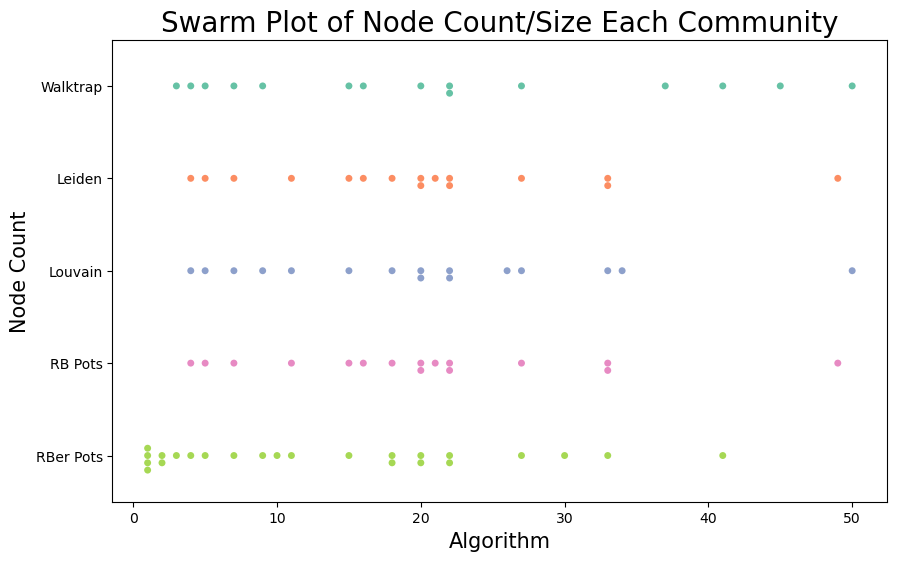

In [88]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='Size', y='Algorithm', data=algo_size, palette='Set2')
plt.title('Swarm Plot of Node Count/Size Each Community', fontsize=20)
plt.xlabel('Algorithm', fontsize=15)
plt.ylabel('Node Count', fontsize=15)
plt.show()

### 18.b. Swarm Plot of Edges Size Each Algorithm

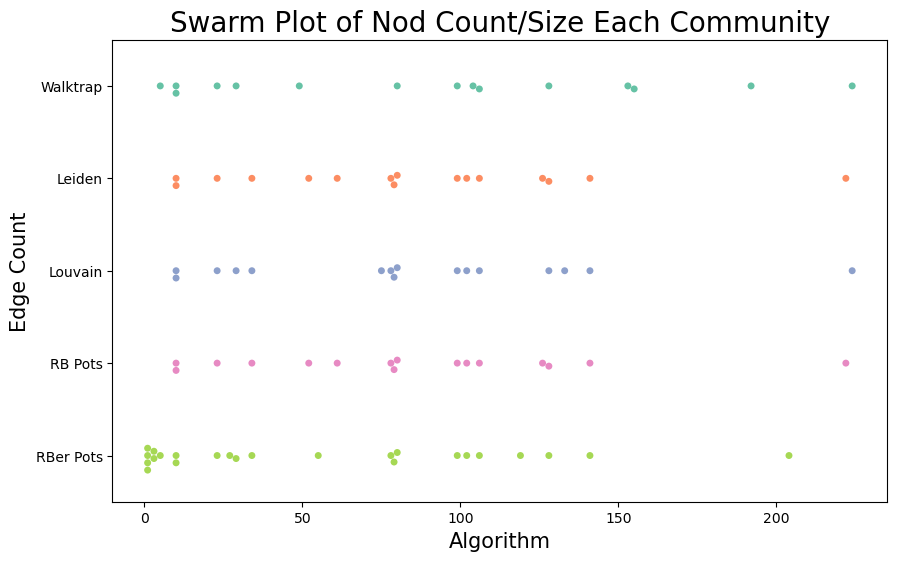

In [89]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='Edge', y='Algorithm', data=algo_edge, palette='Set2')
plt.title('Swarm Plot of Nod Count/Size Each Community', fontsize=20)
plt.xlabel('Algorithm', fontsize=15)
plt.ylabel('Edge Count', fontsize=15)
plt.show()

### 18.c. Swarm Plot of Average Node Degree Each Algorithm

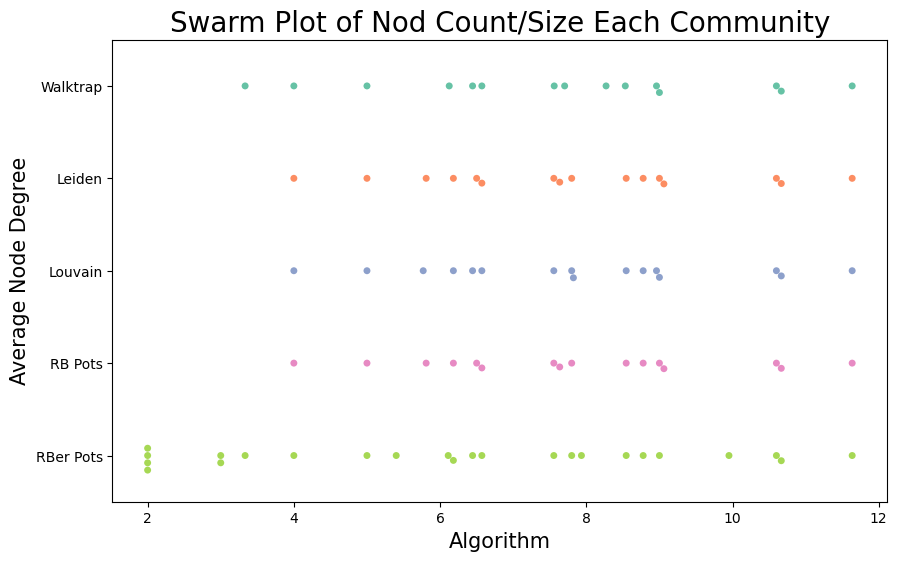

In [90]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='AD', y='Algorithm', data=algo_ad, palette='Set2')
plt.title('Swarm Plot of Nod Count/Size Each Community', fontsize=20)
plt.xlabel('Algorithm', fontsize=15)
plt.ylabel('Average Node Degree', fontsize=15)
plt.show()

## === Exploratory or Replication Zone ===

In [91]:
old_data = [[0.548, 0.51, 0.121, 24.106, 1.207],
[0.701, 0.76, 0.14, 59.499, 1.58],
[-0.01, 0, 0, -1964, -0.098],
[0.711, 0.773, 0.135, 70.804, 1.715],
[0.417, 0.491, 0.143, 26.175, 0.844],
[0.707, 0.779, 0.14, 65.678, 1.601],
[0.549, 0.591, 0.136, 34.864, 1.126],
[0.649, 0.723, 0.124, 54.424, 1.587],
[0.703, 0.762, 0.142, 59.117, 1.571],
[0.678, 0.711, 0.132, 61.066, 1.593],
[0, 0.007, 0.144, 6.587, 0],
[0.71, 0.781, 0.134, 73.272, 1.716],
[0.707, 0.757, 0.135, 66.314, 1.683],
[0.711, 0.773, 0.135, 70.804, 1.715],
[0.707, 0.786, 0.14, 68.667, 1.603],
[0.702, 0.79, 0.139, 63.449, 1.597],
[0.711, 0.773, 0.135, 70.804, 1.715],
[0.622, 0.719, 0.118, 5.528, 1.567],
[0.71, 0.781, 0.134, 73.272, 1.716],
[0.697, 0.78, 0.132, 59.834, 1.691],
[0.707, 0.786, 0.14, 68.667, 1.603]]

old_table = pd.DataFrame(old_data, columns=list('abcde'))

scaler = StandardScaler()
pca = PCA(n_components=1)

old_table = scaler.fit_transform(old_table)
model = pca.fit(old_table)
df = model.transform(old_table)
print(df)
print(pca.components_)
print(pca.explained_variance_)

[[ 0.63036584]
 [-0.8501569 ]
 [ 7.72023359]
 [-0.96378273]
 [ 0.98659069]
 [-0.92734612]
 [ 0.32110125]
 [-0.44232859]
 [-0.87742127]
 [-0.60340524]
 [ 3.66887027]
 [-0.96761846]
 [-0.88894562]
 [-0.96378273]
 [-0.94640124]
 [-0.91919019]
 [-0.96378273]
 [-0.22552343]
 [-0.96761846]
 [-0.87345669]
 [-0.94640124]]
[[-0.46840276 -0.46709713 -0.40151169 -0.4294927  -0.46555721]]
[4.31741388]
